# TP1 RN

En el presente informe se presenta el análisis de un clasificador multiclase para el dataset Fashion MNIST, realizado con  MLP y regresión Softmax. Posteriormente se analiza un problema de regresión, en el cual se estima la inclinación del dígito de entrada.

El principal objetivo de este TP es familizarizarse con los modelos MLP, su entrenamiento y ganar intuición para poder entender otros problemas. 

Por lo tanto el foco fue puesto en las distintas técnicas de regularización más que en intentar obtener el mejor modelo posible. 



In [ ]:
!pip freeze > requirements.txt

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import pandas as pd
import numpy as np

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [100]:
x_train = np.load("/train_images.npy")
y_train = pd.read_csv("/train_labels.csv")
y_train = y_train['label']

random_indices = np.random.choice(60000, size=10000, replace=False)

x_test = x_train[random_indices]
y_test = y_train[random_indices]

# EDA

Primero vemos cada una imagen de cada clase

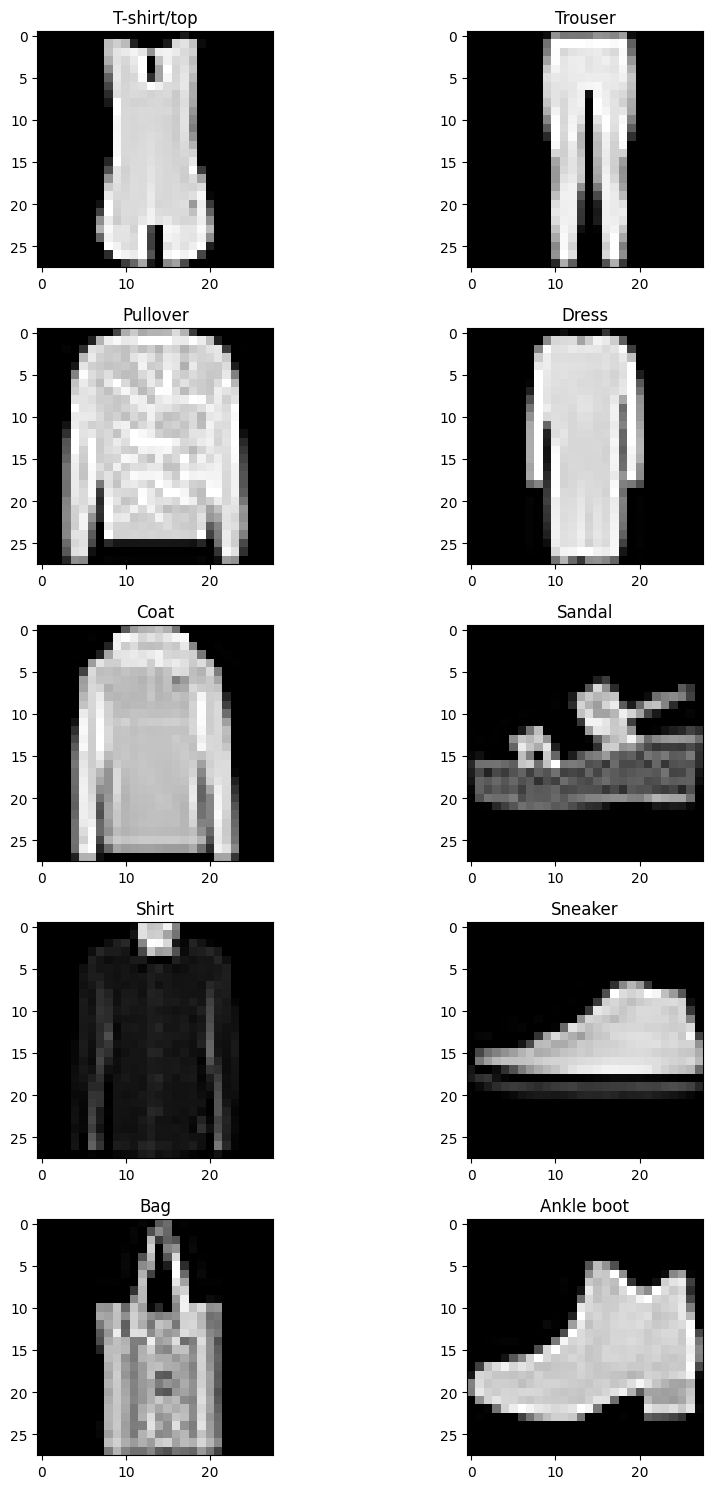

In [101]:
import matplotlib.pyplot as plt
images_class = []
for i in range(0, 10):
  images_class.append(x_train[y_train == i])

fig, axs = plt.subplots(5, 2, figsize=(10, 15))
class_labels = [
                "T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"
                ]
k = 0
for i in range(5):
    for j in range(2):
        axs[i, j].imshow(images_class[k][2], cmap='gray', vmin = 0, vmax = 255)
        axs[i, j].set_title(class_labels[k])
        k = k + 1
plt.tight_layout()

plt.show()

### Histogramas de la distribución de intensidades para cada clase

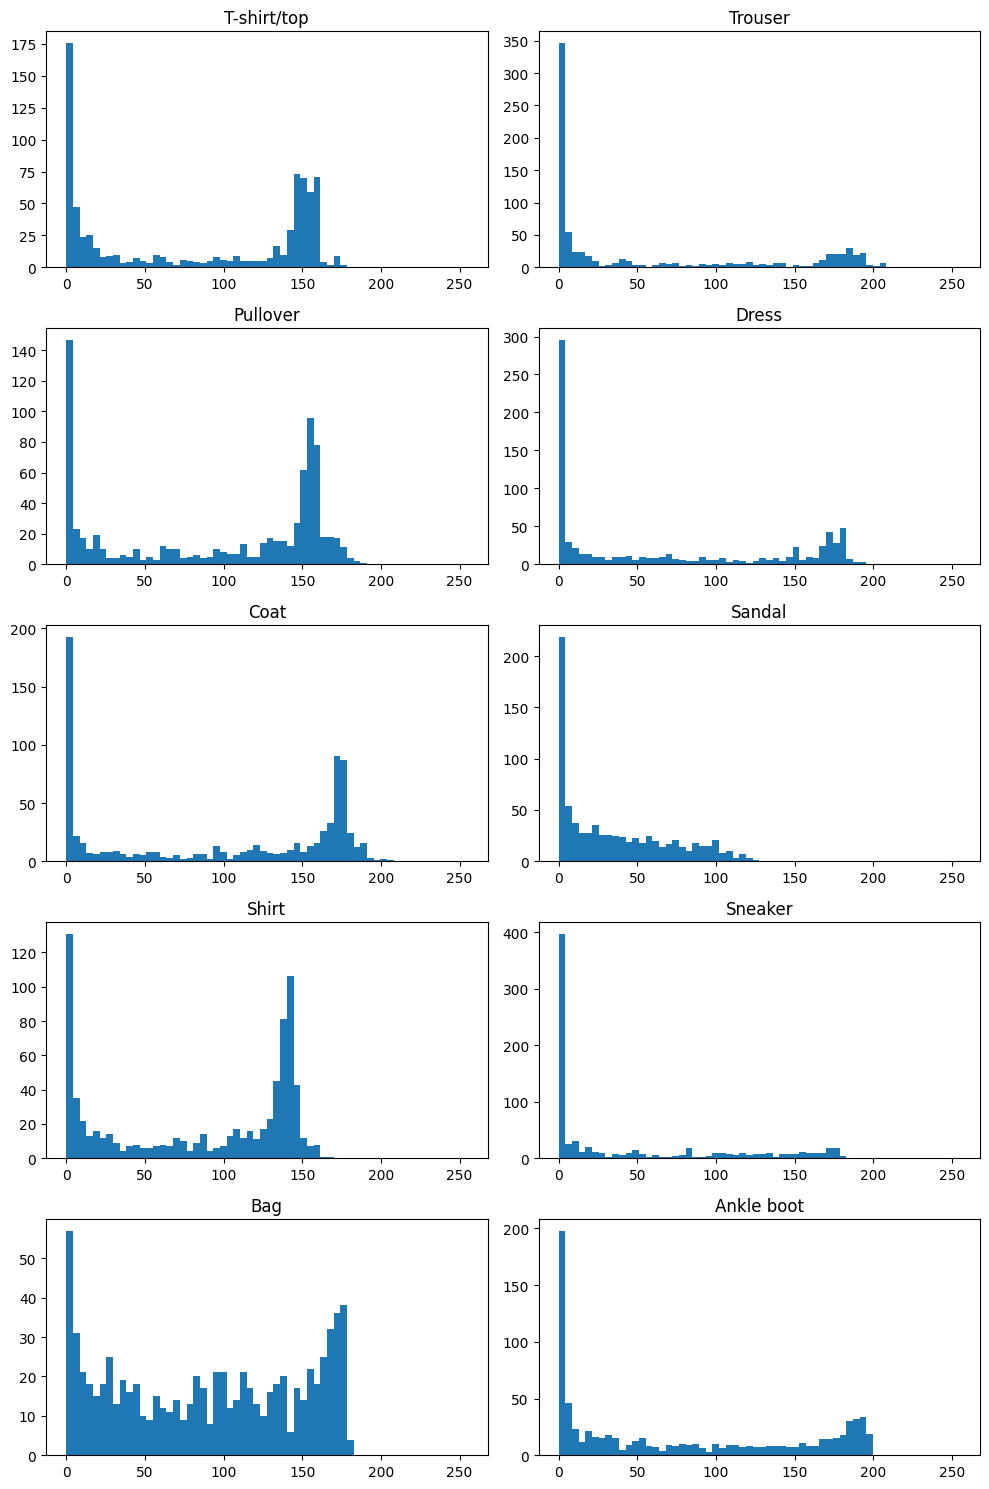

In [5]:
intensities = []
for image_class in images_class:
  list_matrixes = [x for x in image_class]
  averageImage = np.mean(list_matrixes, axis = 0)
  intensities.append(averageImage.flatten()) 
  #plt.hist(intensities, bins = 60, range=(0, 255));

fig, axs = plt.subplots(5, 2, figsize=(10, 15))
class_labels = [
                "T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"
                ]
k = 0
for i in range(5):
    for j in range(2):
        axs[i, j].hist(intensities[k], bins = 60, range=(0, 255));
        axs[i, j].set_title(class_labels[k])
        k = k + 1
plt.tight_layout()

plt.show()


Se notan ciertos patrones para las distintas imagenes, por lo que se podría armar un clasificador básico en base a los histogramas como para tener una baseline.

In [ ]:
print('shape x_train =', x_train.shape)
print('shape y_train =', y_train.shape)
print('shape x_test = ', x_test.shape)
print('shape y_test = ', y_test.shape)

shape x_train = (60000, 28, 28)
shape y_train = (60000,)
shape x_test =  (10000, 28, 28)
shape y_test =  (10000,)


Ahora vemos la distribución de las clases para fashion MNIST

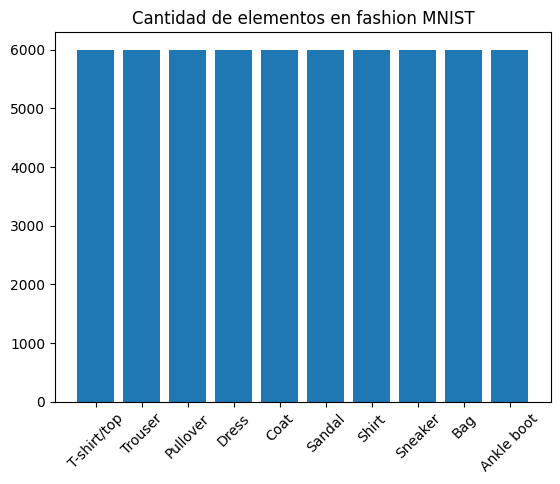

In [64]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

class_counts = [0] * 10  

for label in y_train:
    class_counts[label] += 1

class_labels = [class_labels[i] for i in range(10)]  

plt.bar(class_labels, class_counts)

plt.title("Cantidad de elementos en fashion MNIST")
plt.xticks(rotation=45)
plt.show()

## UMAP

Umap es una librería que bajo ciertas hipótesis del dataset, reduce la dimensionalidad y obtiene una representación capaz de ser visualizada en 2 o 3 dimensiones. Algo parecido se va a ser en el trabajo cuando se coloquen dos nueronas antes de la última capa.

In [84]:
pip install umap-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=6eba88c9393bb7a89887254bc7daf452feaf76ee6050c1abdd35ceb9f7c3eab1
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=ba5be41b5366530579a174be61df8b47c1ef4d907c06b824f37f9be86b47adf7
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [88]:
import umap.umap_ as umap

x_train_umap = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
x_test_umap = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

reducer = umap.UMAP()
embedding = reducer.fit_transform(x_train_umap)


<ipython-input-89-e815b1f6a065>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.colorbar(scatter).set_ticklabels(class_labels)


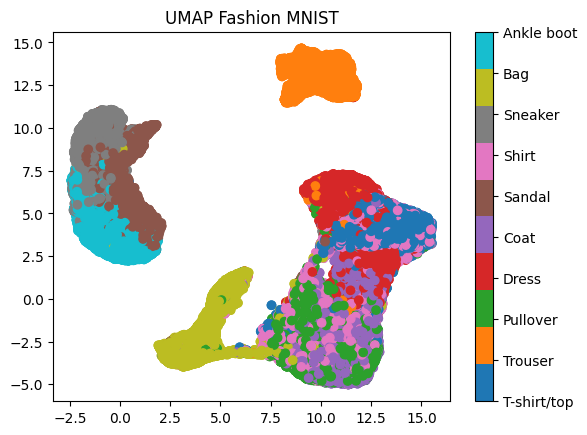

In [89]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap='tab10')

color_map = plt.cm.tab10
num_classes = len(np.unique(y_train))
class_labels = [
                "T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"
                ]

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap=color_map)

plt.colorbar(scatter).set_ticklabels(class_labels)
plt.title('UMAP Fashion MNIST')

plt.show()

Podemos observar que el gráfico tiene bastante sentido, dado que los tipos de zapatillas los pone en clusters separados al del pantalón y buzos/remeras. Se observa también que la red va a tener que dicernir en zonas donde la ropa parece estar totalmente mezclada.

# SOFTMAX

Una sola capa, el modelo más básico, función de activación Softmax, de gran utilidad para clasificación de más de dos categorias.

In [95]:
# Normalizamos la data entre 0 y 1
x_train_softmax = x_train.astype("float32") / 255.0
x_test_softmax = x_test.astype("float32") /255.0

# Estructura de la red
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),             # transforma la imagen de entrada a un vector para procesar correctamente
        layers.Dense(10, activation = 'softmax'),   
    ]
)
model.summary()



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 784)               0         
                                                                 
 dense_94 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [96]:
# keras.losses.SparseCategoricalCrossentropy(), el Sparse, hace el one hot key encoding
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

# Entrenamiento
history = model.fit(x_train_softmax, y_train, batch_size=128, epochs=40, validation_split = 0.2)
# splitiamos parte del train a validation, eso no lo entrena, lo evalua cuando termina cada epoch

# Evaluamos el modelo
test_loss, test_acc = model.evaluate(x_test_softmax, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/40
375/375 [==============================] - 1s 2ms/step - loss: 0.7875 - accuracy: 0.7387 - val_loss: 0.5774 - val_accuracy: 0.8111
Epoch 2/40
375/375 [==============================] - 1s 2ms/step - loss: 0.5349 - accuracy: 0.8222 - val_loss: 0.5175 - val_accuracy: 0.8227
Epoch 3/40
375/375 [==============================] - 1s 3ms/step - loss: 0.4878 - accuracy: 0.8357 - val_loss: 0.4792 - val_accuracy: 0.8373
Epoch 4/40
375/375 [==============================] - 1s 3ms/step - loss: 0.4640 - accuracy: 0.8442 - val_loss: 0.4661 - val_accuracy: 0.8437
Epoch 5/40
375/375 [==============================] - 1s 2ms/step - loss: 0.4480 - accuracy: 0.8482 - val_loss: 0.4504 - val_accuracy: 0.8482
Epoch 6/40
375/375 [==============================] - 1s 3ms/step - loss: 0.4373 - accuracy: 0.8507 - val_loss: 0.4466 - val_accuracy: 0.8457
Epoch 7/40
375/375 [==============================] - 1s 2ms/step - loss: 0.4280 - accuracy: 0.8533 - val_loss: 0.4451 - val_accuracy: 0.8466
Epoch 

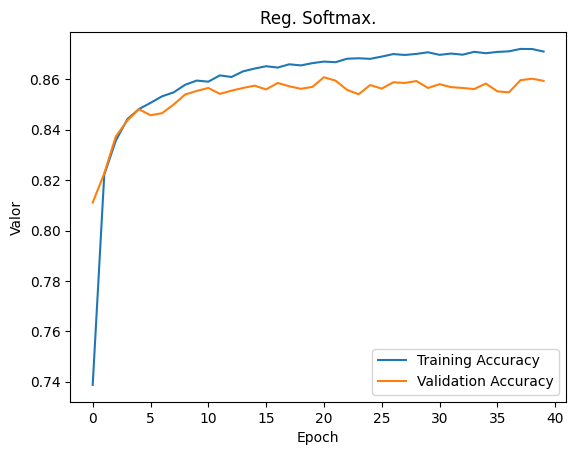

In [97]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Reg. Softmax.')
plt.legend()
plt.show()

Del gráfico anterior podemos ver, que para esta red, el entrenamiento comienza a overfitear. Resulta de interés comenzar a variar parámetros y probar técnicas para mejorar el acc de validación. Estas metodologías se aplicarán al modelo MLP

# MLP

Para MLP se hizo un análisis mas profundo, dado que tenemos una red de mayor complejidad, intuitivamente podemos pensar que un mayor esfuerzo se va a necesitar para poder sacarle su potencial

In [6]:
x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") /255.0

## Distintas funciones de activación

Se analizarán distintas funciones de activación, sin tener todavía la mejor red, pero con una red "simple" podemos ver el impacto de las distintas funciones de activación. Aunque es **importante** entender que las conclusiones que se puedan obtener de acá pueden tener cierto sesgo debido a que quizás para otro tipo de red y forma de entrenamiento su performance puede ser distinta.

### Softmax

Está función resulta de gran utilidad cuando se quiere una salida que se pueda interpretar como una probabilidad, sin embargo para capas intermedias, su forma asintótica puede hacer que su entrenamiento sea complicado dado que el gradiente en esas zonas se hace chico. (*Vanishing Gradient*)

In [85]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'softmax'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 dense_59 (Dense)            (None, 100)               78500     
                                                                 
 dense_60 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [86]:
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=128, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
375/375 [==============================] - 2s 4ms/step - loss: 1.8842 - accuracy: 0.6760 - val_loss: 1.6095 - val_accuracy: 0.7298
Epoch 2/35
375/375 [==============================] - 2s 5ms/step - loss: 1.4163 - accuracy: 0.7388 - val_loss: 1.2454 - val_accuracy: 0.7563
Epoch 3/35
375/375 [==============================] - 2s 4ms/step - loss: 1.1112 - accuracy: 0.7669 - val_loss: 1.0012 - val_accuracy: 0.7781
Epoch 4/35
375/375 [==============================] - 1s 4ms/step - loss: 0.9046 - accuracy: 0.7883 - val_loss: 0.8352 - val_accuracy: 0.7959
Epoch 5/35
375/375 [==============================] - 1s 3ms/step - loss: 0.7667 - accuracy: 0.8001 - val_loss: 0.7290 - val_accuracy: 0.8040
Epoch 6/35
375/375 [==============================] - 1s 3ms/step - loss: 0.6772 - accuracy: 0.8086 - val_loss: 0.6630 - val_accuracy: 0.8077
Epoch 7/35
375/375 [==============================] - 1s 3ms/step - loss: 0.6181 - accuracy: 0.8134 - val_loss: 0.6162 - val_accuracy: 0.8126
Epoch 

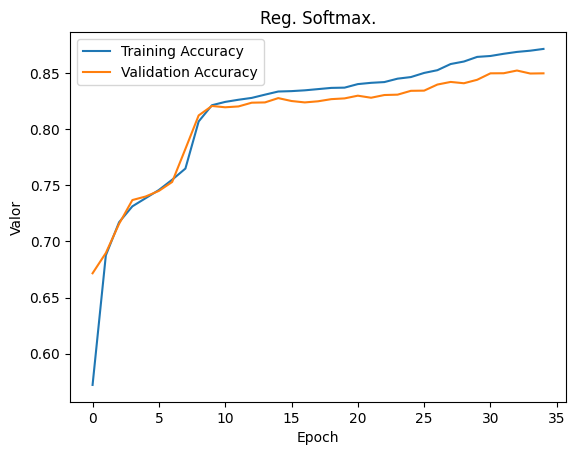

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Reg. Softmax.')
plt.legend()
plt.show()

### ReLU 
ReLU es una función de activación con una alta eficiencia computacional, dado que:

 $\text{ReLU}(x) = \begin{cases} 
      0 & \text{si } x < 0 \\
      x & \text{si } x \geq 0 
   \end{cases}
   $
   
Su evaluación resulta trivial


In [16]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [17]:
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=128, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
375/375 [==============================] - 2s 4ms/step - loss: 0.5915 - accuracy: 0.7982 - val_loss: 0.4672 - val_accuracy: 0.8372
Epoch 2/35
375/375 [==============================] - 1s 4ms/step - loss: 0.4300 - accuracy: 0.8503 - val_loss: 0.4194 - val_accuracy: 0.8512
Epoch 3/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3875 - accuracy: 0.8629 - val_loss: 0.3896 - val_accuracy: 0.8621
Epoch 4/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3601 - accuracy: 0.8735 - val_loss: 0.3975 - val_accuracy: 0.8549
Epoch 5/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3400 - accuracy: 0.8781 - val_loss: 0.3841 - val_accuracy: 0.8667
Epoch 6/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3253 - accuracy: 0.8834 - val_loss: 0.3426 - val_accuracy: 0.8794
Epoch 7/35
375/375 [==============================] - 2s 5ms/step - loss: 0.3111 - accuracy: 0.8876 - val_loss: 0.3360 - val_accuracy: 0.8801
Epoch 

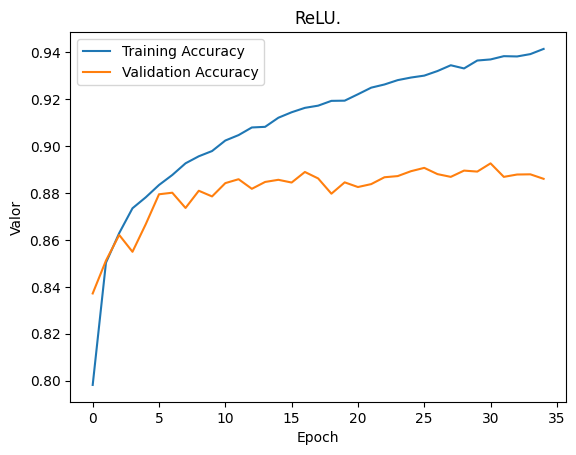

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('ReLU.')
plt.legend()
plt.show()

Se comienza a notar un alto overfitting

### Tanh
La Tanh es otra función de activación, similar a Softmax, pero esta se encuentra centrada en 0, por lo que puede tener ventajas en el entrenamiento frente a la softmax por ejemplo. 

In [32]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'tanh'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               78500     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [33]:
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=128, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
375/375 [==============================] - 3s 4ms/step - loss: 0.5678 - accuracy: 0.8033 - val_loss: 0.4476 - val_accuracy: 0.8405
Epoch 2/35
375/375 [==============================] - 2s 4ms/step - loss: 0.4113 - accuracy: 0.8531 - val_loss: 0.3953 - val_accuracy: 0.8580
Epoch 3/35
375/375 [==============================] - 2s 5ms/step - loss: 0.3723 - accuracy: 0.8661 - val_loss: 0.3809 - val_accuracy: 0.8618
Epoch 4/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3493 - accuracy: 0.8738 - val_loss: 0.3548 - val_accuracy: 0.8715
Epoch 5/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3319 - accuracy: 0.8797 - val_loss: 0.3757 - val_accuracy: 0.8663
Epoch 6/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3180 - accuracy: 0.8863 - val_loss: 0.3359 - val_accuracy: 0.8777
Epoch 7/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3029 - accuracy: 0.8909 - val_loss: 0.3247 - val_accuracy: 0.8813
Epoch 

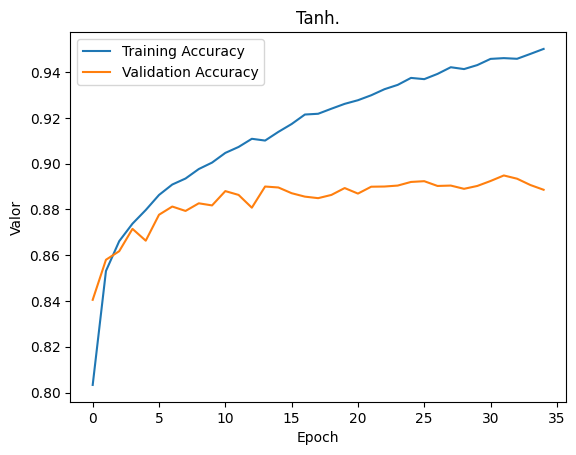

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Tanh.')
plt.legend()
plt.show()

### Leaky ReLU

Leaky ReLU, agrega una pendiente para las entradas negativas, esto es una ventaja sobre ReLU, la cual deja de entrenar a las neuronas cuando tienen una entrada negativa. (por tener gradiente 0).

$\text{LeakyReLU}(x) = \begin{cases} 
      x & \text{si } x \geq 0 \\
      \alpha x & \text{si } x < 0 
   \end{cases}
$

In [25]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = tf.keras.layers.LeakyReLU(alpha=0.3)),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [26]:
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=128, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


Epoch 1/35
375/375 [==============================] - 3s 5ms/step - loss: 0.5885 - accuracy: 0.7963 - val_loss: 0.4637 - val_accuracy: 0.8419
Epoch 2/35
375/375 [==============================] - 2s 4ms/step - loss: 0.4412 - accuracy: 0.8466 - val_loss: 0.4322 - val_accuracy: 0.8468
Epoch 3/35
375/375 [==============================] - 1s 4ms/step - loss: 0.4022 - accuracy: 0.8580 - val_loss: 0.3999 - val_accuracy: 0.8590
Epoch 4/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3785 - accuracy: 0.8658 - val_loss: 0.4024 - val_accuracy: 0.8523
Epoch 5/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3612 - accuracy: 0.8719 - val_loss: 0.4243 - val_accuracy: 0.8556
Epoch 6/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3504 - accuracy: 0.8747 - val_loss: 0.3710 - val_accuracy: 0.8689
Epoch 7/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8784 - val_loss: 0.3525 - val_accuracy: 0.8752
Epoch 

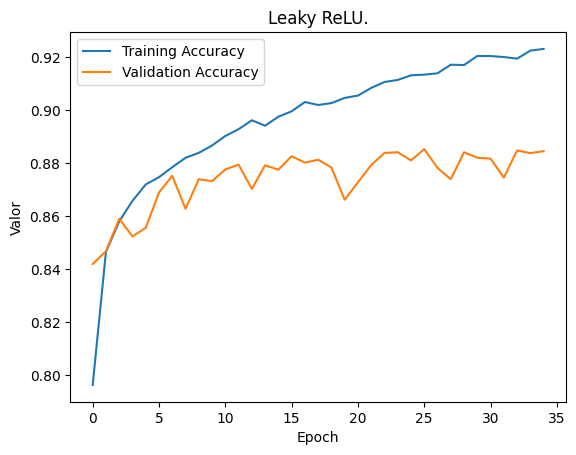

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Leaky ReLU.')
plt.legend()
plt.show()

### ELU
Similar a Leaky ReLU, la diferencia es que está mas "suavizada" que LReLU.

$\text{ELU}(x) = \begin{cases} 
      x & \text{if } x \geq 0 \\
      \alpha \left( e^x - 1 \right) & \text{if } x < 0 
   \end{cases}$

In [28]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = tf.keras.layers.ELU(alpha=1.0)),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               78500     
                                                                 
 dense_15 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [29]:
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=128, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


Epoch 1/35
375/375 [==============================] - 3s 5ms/step - loss: 0.5776 - accuracy: 0.7994 - val_loss: 0.4619 - val_accuracy: 0.8370
Epoch 2/35
375/375 [==============================] - 2s 5ms/step - loss: 0.4352 - accuracy: 0.8460 - val_loss: 0.4196 - val_accuracy: 0.8490
Epoch 3/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3938 - accuracy: 0.8586 - val_loss: 0.4041 - val_accuracy: 0.8526
Epoch 4/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3688 - accuracy: 0.8671 - val_loss: 0.3917 - val_accuracy: 0.8547
Epoch 5/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3498 - accuracy: 0.8740 - val_loss: 0.3945 - val_accuracy: 0.8608
Epoch 6/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3366 - accuracy: 0.8781 - val_loss: 0.3531 - val_accuracy: 0.8715
Epoch 7/35
375/375 [==============================] - 1s 3ms/step - loss: 0.3216 - accuracy: 0.8832 - val_loss: 0.3395 - val_accuracy: 0.8767
Epoch 

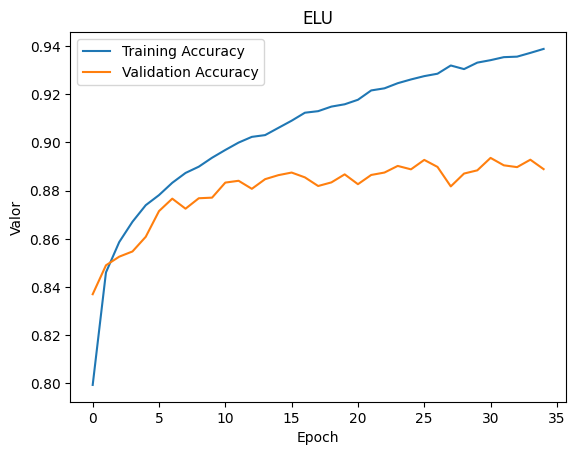

In [31]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('ELU')
plt.legend()
plt.show()

El test Accuracy terminó dando similar entre todas las funciones de activación, salvo por la softmax que mostró 3 puntos porcentuales menos que las demás. Dado que son solo 2 capas, el vanishing gradient de la tanh no impactó mucho. 

## Distintos optimizadores

Con la misma filosofía que para las funciones de activación, sobre un modelo básico, buscamos ganar una noción de los optimizadores

In [87]:
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_61 (Dense)            (None, 100)               78500     
                                                                 
 dense_62 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


### Adam

Adam suele ser conocido por ser uno de los optimizadores mas sofisticados, y el primero que se probaría en un problema

In [88]:
modelMLP = keras.models.clone_model(modelBase)

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


Epoch 1/35
188/188 [==============================] - 3s 7ms/step - loss: 0.6820 - accuracy: 0.7700 - val_loss: 0.5088 - val_accuracy: 0.8246
Epoch 2/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4535 - accuracy: 0.8425 - val_loss: 0.4431 - val_accuracy: 0.8444
Epoch 3/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4066 - accuracy: 0.8583 - val_loss: 0.4099 - val_accuracy: 0.8538
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3803 - accuracy: 0.8664 - val_loss: 0.3890 - val_accuracy: 0.8616
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3548 - accuracy: 0.8750 - val_loss: 0.3756 - val_accuracy: 0.8684
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3425 - accuracy: 0.8792 - val_loss: 0.3569 - val_accuracy: 0.8724
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3278 - accuracy: 0.8817 - val_loss: 0.3541 - val_accuracy: 0.8752
Epoch 

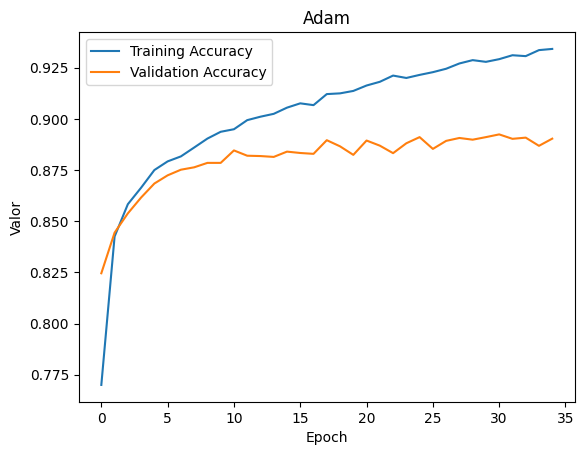

In [89]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Adam')
plt.legend()
plt.show()

### SGD

Más simple que Adam

In [90]:
modelMLP = keras.models.clone_model(modelBase)

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
188/188 [==============================] - 1s 5ms/step - loss: 2.0506 - accuracy: 0.2704 - val_loss: 1.8612 - val_accuracy: 0.4320
Epoch 2/35
188/188 [==============================] - 1s 4ms/step - loss: 1.7363 - accuracy: 0.5267 - val_loss: 1.6194 - val_accuracy: 0.5828
Epoch 3/35
188/188 [==============================] - 1s 4ms/step - loss: 1.5351 - accuracy: 0.6061 - val_loss: 1.4496 - val_accuracy: 0.6248
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 1.3912 - accuracy: 0.6353 - val_loss: 1.3256 - val_accuracy: 0.6485
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 1.2840 - accuracy: 0.6515 - val_loss: 1.2314 - val_accuracy: 0.6624
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 1.2014 - accuracy: 0.6641 - val_loss: 1.1578 - val_accuracy: 0.6737
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 1.1358 - accuracy: 0.6728 - val_loss: 1.0987 - val_accuracy: 0.6822
Epoch 

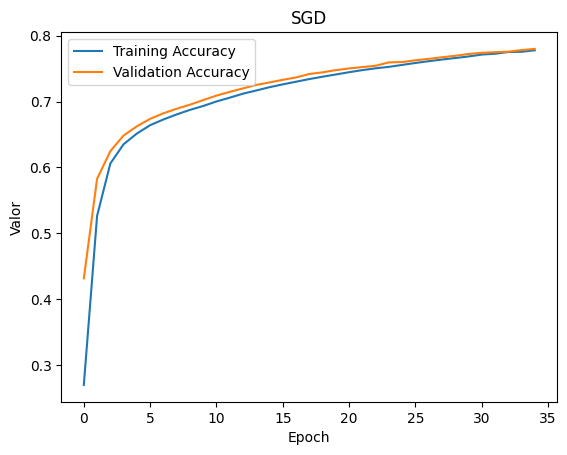

In [91]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('SGD')
plt.legend()
plt.show()

### RMS prop
Más simple que Adam, mas complejo que SGD

In [92]:
modelMLP = keras.models.clone_model(modelBase)

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
188/188 [==============================] - 22s 5ms/step - loss: 0.6817 - accuracy: 0.7649 - val_loss: 0.5053 - val_accuracy: 0.8251
Epoch 2/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4772 - accuracy: 0.8328 - val_loss: 0.4504 - val_accuracy: 0.8397
Epoch 3/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4251 - accuracy: 0.8489 - val_loss: 0.4166 - val_accuracy: 0.8528
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3916 - accuracy: 0.8595 - val_loss: 0.4177 - val_accuracy: 0.8453
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.8683 - val_loss: 0.3828 - val_accuracy: 0.8648
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3489 - accuracy: 0.8725 - val_loss: 0.3728 - val_accuracy: 0.8677
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3342 - accuracy: 0.8791 - val_loss: 0.3609 - val_accuracy: 0.8721
Epoch

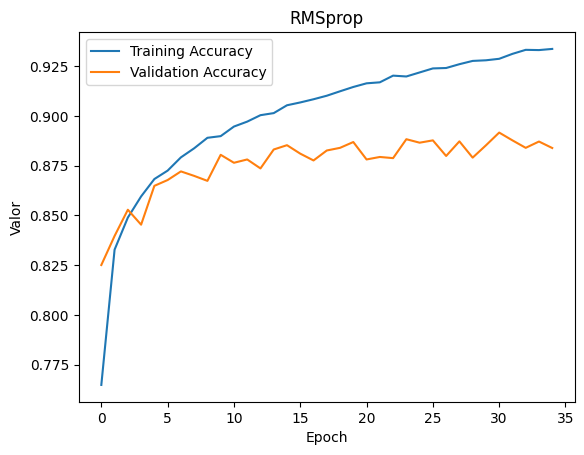

In [93]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('RMSprop')
plt.legend()
plt.show()

### Adagrad

In [94]:
modelMLP = keras.models.clone_model(modelBase)

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adagrad(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
188/188 [==============================] - 2s 7ms/step - loss: 1.9329 - accuracy: 0.3833 - val_loss: 1.6089 - val_accuracy: 0.5977
Epoch 2/35
188/188 [==============================] - 1s 6ms/step - loss: 1.4200 - accuracy: 0.6477 - val_loss: 1.2658 - val_accuracy: 0.6697
Epoch 3/35
188/188 [==============================] - 1s 5ms/step - loss: 1.1758 - accuracy: 0.6743 - val_loss: 1.0915 - val_accuracy: 0.6886
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 1.0438 - accuracy: 0.6905 - val_loss: 0.9900 - val_accuracy: 0.7034
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 0.9610 - accuracy: 0.7028 - val_loss: 0.9220 - val_accuracy: 0.7138
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 0.9034 - accuracy: 0.7153 - val_loss: 0.8732 - val_accuracy: 0.7251
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 0.8604 - accuracy: 0.7257 - val_loss: 0.8356 - val_accuracy: 0.7350
Epoch 

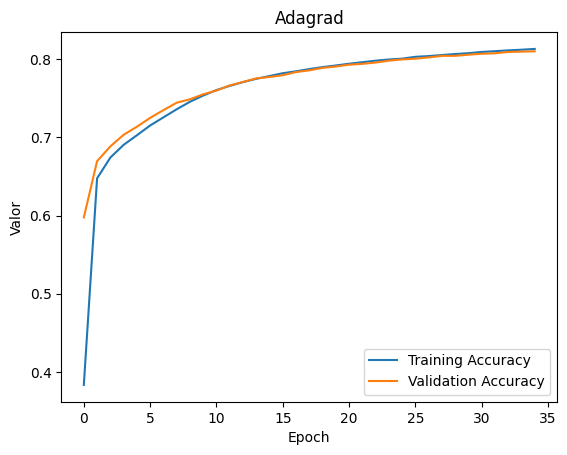

In [95]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Adagrad')
plt.legend()
plt.show()

### Adamax



In [96]:
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adamax(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
188/188 [==============================] - 2s 5ms/step - loss: 0.7647 - accuracy: 0.7488 - val_loss: 0.5711 - val_accuracy: 0.8104
Epoch 2/35
188/188 [==============================] - 1s 4ms/step - loss: 0.5265 - accuracy: 0.8246 - val_loss: 0.5016 - val_accuracy: 0.8270
Epoch 3/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4737 - accuracy: 0.8393 - val_loss: 0.4632 - val_accuracy: 0.8407
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4461 - accuracy: 0.8496 - val_loss: 0.4458 - val_accuracy: 0.8489
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4232 - accuracy: 0.8567 - val_loss: 0.4271 - val_accuracy: 0.8542
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 0.4078 - accuracy: 0.8607 - val_loss: 0.4286 - val_accuracy: 0.8535
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3956 - accuracy: 0.8638 - val_loss: 0.4139 - val_accuracy: 0.8590
Epoch 

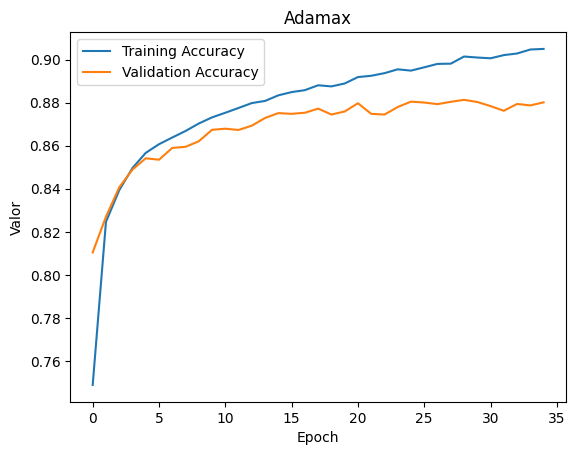

In [97]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Adamax')
plt.legend()
plt.show()

### Nadam

In [98]:
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=35, validation_split= 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/35
188/188 [==============================] - 2s 7ms/step - loss: 0.6918 - accuracy: 0.7674 - val_loss: 0.4843 - val_accuracy: 0.8374
Epoch 2/35
188/188 [==============================] - 1s 7ms/step - loss: 0.4408 - accuracy: 0.8485 - val_loss: 0.4233 - val_accuracy: 0.8526
Epoch 3/35
188/188 [==============================] - 1s 5ms/step - loss: 0.3963 - accuracy: 0.8620 - val_loss: 0.4052 - val_accuracy: 0.8615
Epoch 4/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3705 - accuracy: 0.8715 - val_loss: 0.3794 - val_accuracy: 0.8648
Epoch 5/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3514 - accuracy: 0.8768 - val_loss: 0.3899 - val_accuracy: 0.8656
Epoch 6/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3369 - accuracy: 0.8815 - val_loss: 0.3587 - val_accuracy: 0.8756
Epoch 7/35
188/188 [==============================] - 1s 4ms/step - loss: 0.3238 - accuracy: 0.8848 - val_loss: 0.3526 - val_accuracy: 0.8764
Epoch 

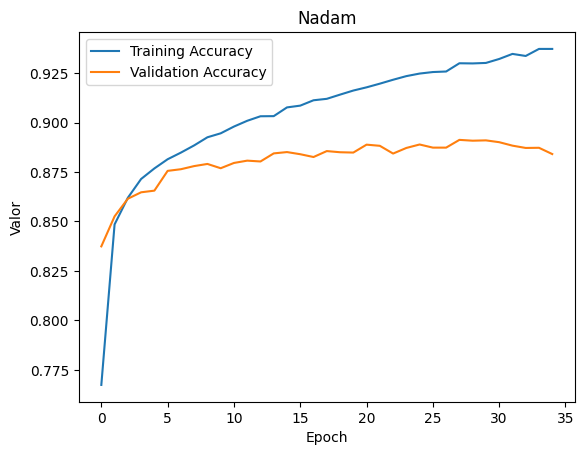

In [99]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('Nadam')
plt.legend()
plt.show()

## Distintos tamaños de Red

Disintos tamaños de red (cantidad de capas y neuronas por capa) son evaluados.

## 2 capas de 100 y 10

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               78500     
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5266 - accuracy: 0.8141 - val_loss: 0.4924 - val_accuracy: 0.8282
Epoch 2/25
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3924 - accuracy: 0.8590 - val_loss: 0.3742 - val_accuracy: 0.8682
Epoch 3/25
1500/1500 [====

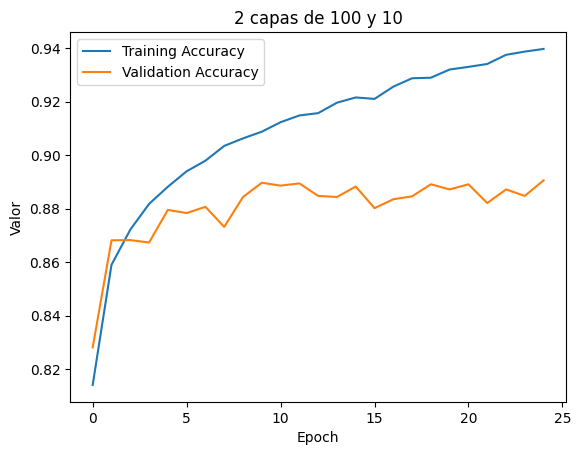

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=25, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('2 capas de 100 y 10')
plt.legend()
plt.show()


## 2 capas de 255 y 10

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 255)               200175    
                                                                 
 dense_21 (Dense)            (None, 10)                2560      
                                                                 
Total params: 202,735
Trainable params: 202,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [==============================] - 10s 6ms/step - loss: 0.5033 - accuracy: 0.8225 - val_loss: 0.4368 - val_accuracy: 0.8426
Epoch 2/25
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3773 - accuracy: 0.8637 - val_loss: 0.3725 - val_accuracy: 0.8640
Epoch 3/25
1500/1500 [

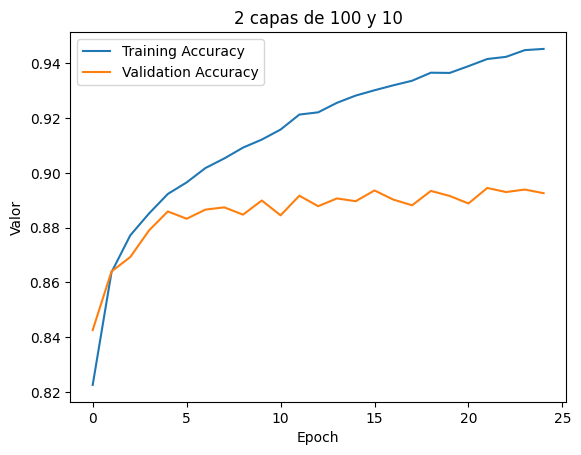

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(255, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=25, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('2 capas de 100 y 10')
plt.legend()
plt.show()


## 2 capas de 1024 y 10

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              803840    
                                                                 
 dense_23 (Dense)            (None, 10)                10250     
                                                                 
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [==============================] - 27s 17ms/step - loss: 0.4852 - accuracy: 0.8252 - val_loss: 0.4045 - val_accuracy: 0.8495
Epoch 2/25
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3689 - accuracy: 0.8640 - val_loss: 0.3990 - val_accuracy: 0.8571
Epoch 3/25
1500/150

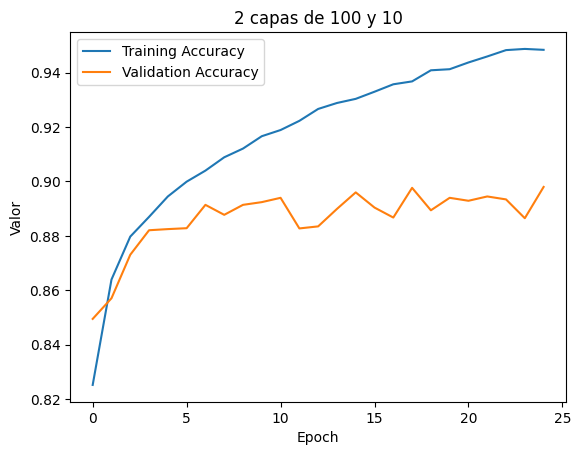

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(1024, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=25, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('2 capas de 100 y 10')
plt.legend()
plt.show()


## 3 capas de 100, 100 y 10

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [==============================] - 8s 5ms/step - loss: 1.7069 - accuracy: 0.3596 - val_loss: 1.4383 - val_accuracy: 0.3988
Epoch 2/25
1500/1500 [===============

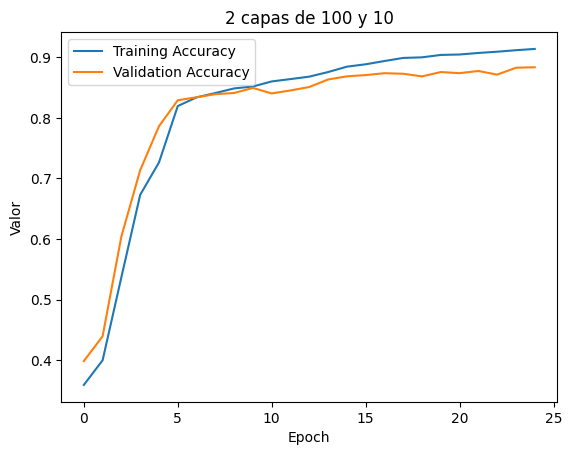

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(100, activation = 'softmax'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=25, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('2 capas de 100 y 10')
plt.legend()
plt.show()


## 4 capas de 64, 64, 100 y 10

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                50240     
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 dense_45 (Dense)            (None, 100)               6500      
                                                                 
 dense_46 (Dense)            (None, 10)                1010      
                                                                 
Total params: 61,910
Trainable params: 61,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [===========================

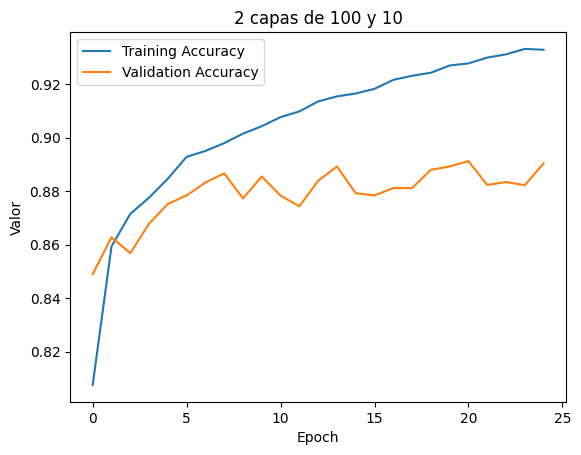

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=25, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('2 capas de 100 y 10')
plt.legend()
plt.show()


## Distintos Learning Rates

Se prueban distintos learning rates para Adam sobre un modelo básico.

In [100]:
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

learningRates = {"LR = 1e-3": 1e-3, "LR = 10e-3": 10e-3, "LR = 50e-3": 50e-3}
train_acc_ls = []
val_acc_ls = []
for i, (keyLr, valLr) in enumerate(learningRates.items()):
  modelMLP = keras.models.clone_model(modelBase)
  modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=valLr), metrics=["accuracy"])

  history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=30, validation_split = 0.2)

  test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
  print("Test accuracy:", test_acc)
  train_acc_ls.append(history.history['accuracy'])
  val_acc_ls.append(history.history['val_accuracy'] )





Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 100)               78500     
                                                                 
 dense_64 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
188/188 [==============================] - 2s 5ms/step - loss: 0.6587 - accuracy: 0.7793 - val_loss: 0.4829 - val_accuracy: 0.8359
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 0.4482 - accuracy: 0.8462 - val_loss: 0.4363 - val_accuracy: 0.8492
Epoch 3/30
188/188 [=========

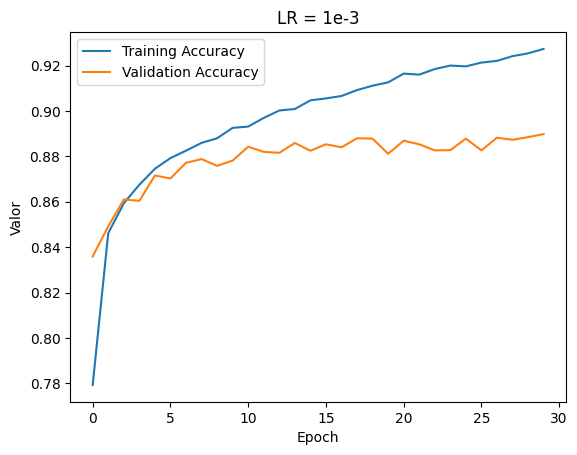

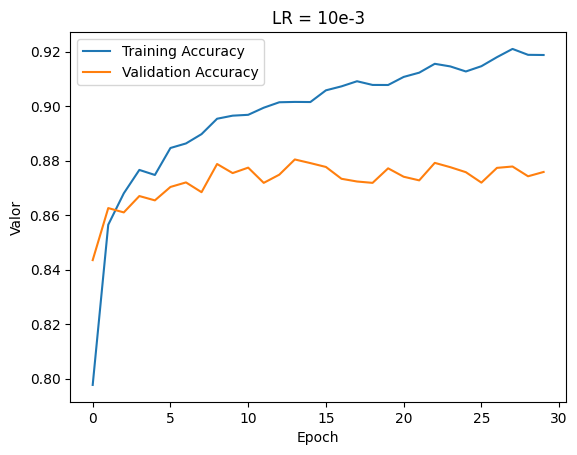

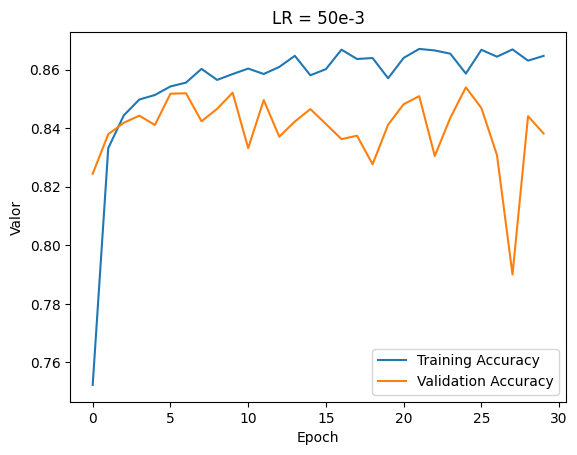

In [101]:
for i, (keyLr, valLr) in enumerate(learningRates.items()):
  plt.plot(train_acc_ls[i], label='Training Accuracy')
  plt.plot(val_acc_ls[i], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Valor')
  plt.title(keyLr)
  plt.legend()
  plt.show()

## Distintos Batch Size


In [102]:
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(100, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

batch_sizes = [32, 64, 128, 512]
acc_train = []
acc_test = []
for i, batch_values in enumerate(batch_sizes):
  modelMLP = keras.models.clone_model(modelBase)
  modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

  history = modelMLP.fit(x_train_mlp, y_train, batch_size=batch_values, epochs=25, validation_split = 0.2)

  test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
  print("Test accuracy:", test_acc)
  acc_train.append(history.history['accuracy'])
  acc_test.append(history.history['val_accuracy'])




Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 dense_65 (Dense)            (None, 100)               78500     
                                                                 
 dense_66 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5288 - accuracy: 0.8160 - val_loss: 0.4367 - val_accuracy: 0.8443
Epoch 2/25
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3945 - accuracy: 0.8605 - val_loss: 0.4068 - val_accuracy: 0.8546
Epoch 3/25
1500/1500 [===

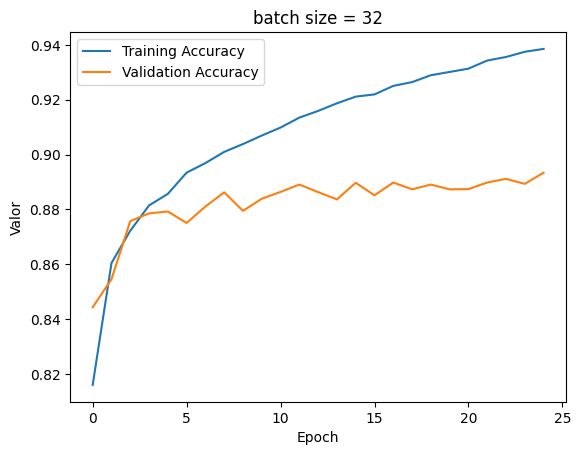

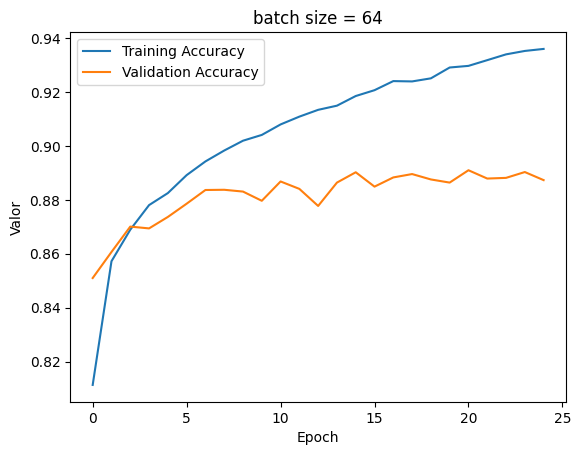

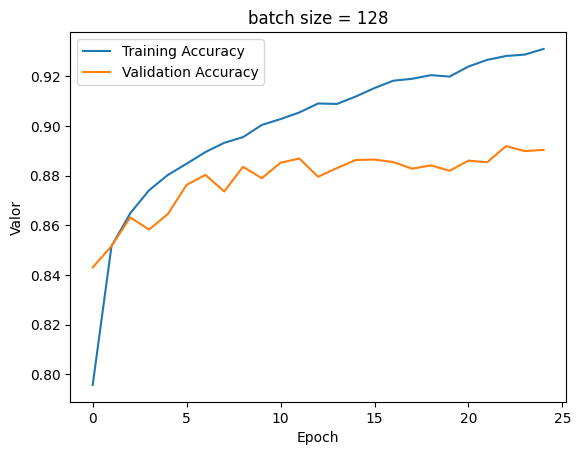

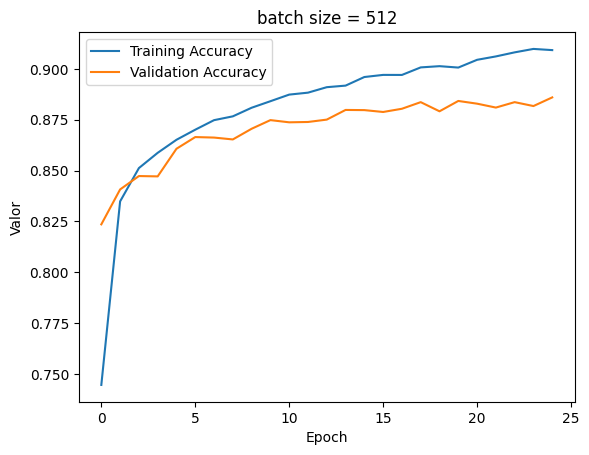

In [103]:
for i, batch_values in enumerate(batch_sizes):
  plt.plot(acc_train[i], label='Training Accuracy')
  plt.plot(acc_test[i], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Valor')
  plt.title('batch size = ' + str(batch_values))
  plt.legend()
  plt.show()

## Dropout Rates

Ahora se evalúa una técnica de regularización. Para esto usamos una red con 3 capas y variamos los droput rates. 

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-t

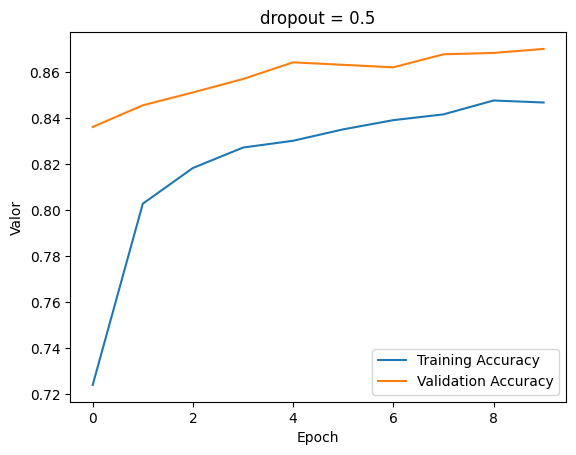

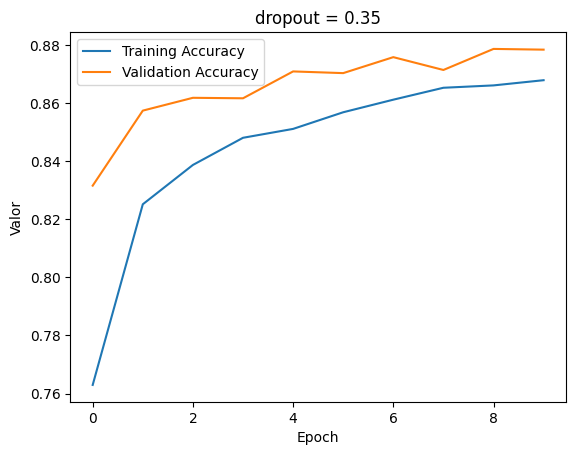

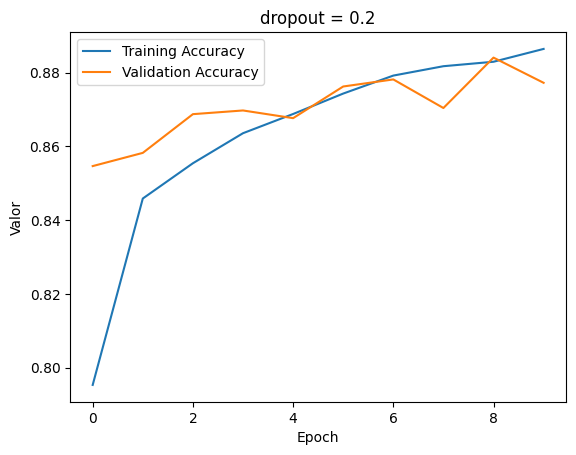

In [ ]:
dropout_values = [0.5, 0.35, 0.2]
acc_train = []
acc_test = []
for i, dropoutVals in enumerate(dropout_values):
  modelMLP = keras.Sequential(
      [
          keras.Input(shape=(28, 28)),
          layers.Flatten(),
          layers.Dense(128, activation = 'relu'),
          layers.Dropout(dropoutVals),
          layers.Dense(128, activation = 'relu'),
          layers.Dropout(dropoutVals),
          layers.Dense(10, activation = 'softmax')
      ]
  )
  modelMLP.summary()

  modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

  history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=10, validation_split = 0.2)

  test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
  print("Test accuracy:", test_acc)
  acc_train.append(history.history['accuracy'])
  acc_test.append(history.history['val_accuracy'])

for i, dropoutVals in enumerate(dropout_values):
  plt.plot(acc_train[i], label='Training Accuracy')
  plt.plot(acc_test[i], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Valor')
  plt.title('dropout = ' + str(dropoutVals))
  plt.legend()
  plt.show()


## Batch Normalization

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_62 (Dense)            (None, 10)              

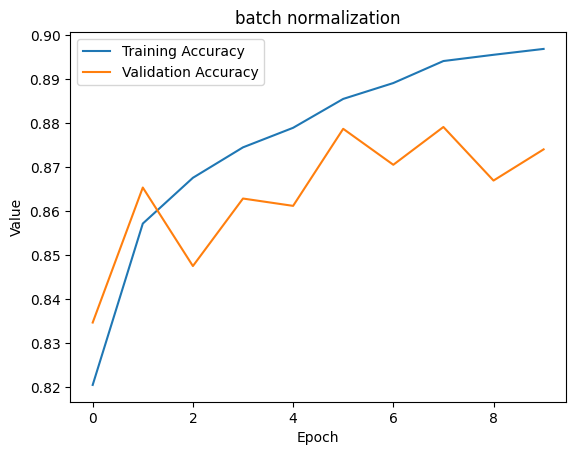

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 128)               100480    
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dense_65 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4967 - accuracy: 0.8243 - val_loss: 0.4373 - val_accuracy: 0.8425
Epoch 2/10
1875/1875 [============

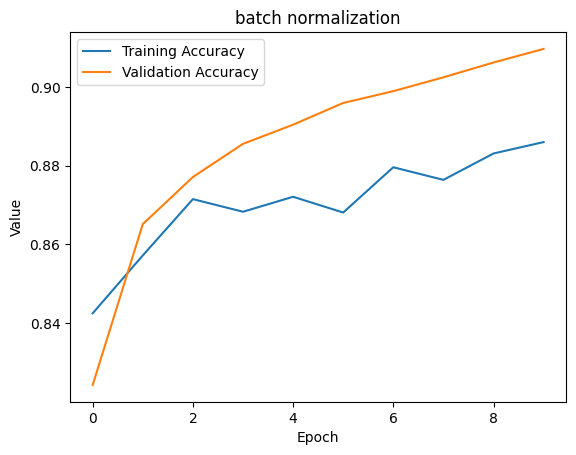

In [ ]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.BatchNormalization(momentum = 0.99),
        layers.Dense(64, activation = 'relu'),
        layers.BatchNormalization(momentum = 0.99),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=10, validation_split = 0.2)

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('batch normalization')
plt.legend()
plt.show()

modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=32, epochs=10, validation_data = (x_test_mlp, y_test))

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


plt.plot(history.history['val_accuracy'], label='Training Accuracy')
plt.plot(history.history['accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('batch normalization')
plt.legend()
plt.show()


## Inicializadores de peso


In [ ]:
model = []
model.append(keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu',  kernel_initializer = 'glorot_uniform'),
        layers.Dense(64, activation = 'relu',  kernel_initializer = 'glorot_uniform'),
        layers.Dense(10, activation = 'softmax', kernel_initializer = 'glorot_uniform')
    ]
))
model.append(keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu',  kernel_initializer = 'glorot_normal'),
        layers.Dense(64, activation = 'relu',  kernel_initializer = 'glorot_normal'),
        layers.Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')
    ]
))
model.append(keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu',  kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dense(64, activation = 'relu',  kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dense(10, activation = 'softmax', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0))
    ]
))
model.append(keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu',  kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dense(64, activation = 'relu',  kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dense(10, activation = 'softmax', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10))
    ]
))
acc_test = []
acc_val = []
for i in range(0, 4):
  model[i].compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

  history = model[i].fit(x_train_mlp, y_train, batch_size=32, epochs=10, validation_split = 0.2)

  test_loss, test_acc = model[i].evaluate(x_test_mlp, y_test, verbose=2)
  print("Test accuracy:", test_acc)
  acc_test.append(history.history['accuracy'])
  acc_val.append(history.history['val_accuracy'])

labels = ['glorot_uniform', 'glorot_normal', 'normal(0, 1)', 'normal(0, 10)']



Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5067 - accuracy: 0.8199 - val_loss: 0.4072 - val_accuracy: 0.8497
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3770 - accuracy: 0.8621 - val_loss: 0.3552 - val_accuracy: 0.8704
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3397 - accuracy: 0.8753 - val_loss: 0.3468 - val_accuracy: 0.8728
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3151 - accuracy: 0.8846 - val_loss: 0.3455 - val_accuracy: 0.8740
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2954 - accuracy: 0.8905 - val_loss: 0.3282 - val_accuracy: 0.8793
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2815 - accuracy: 0.8939 - val_loss: 0.3282 - val_accuracy: 0.8823
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2711 - accuracy: 0.8980 - val_loss: 0.3204 - val_accuracy:

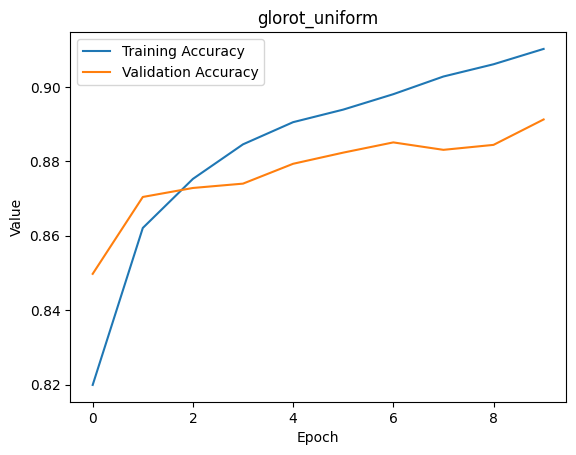

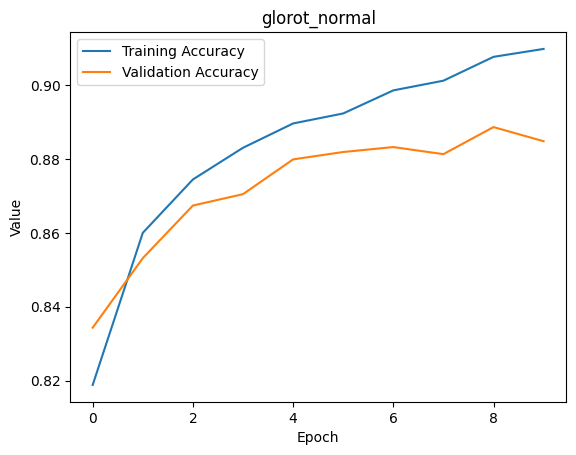

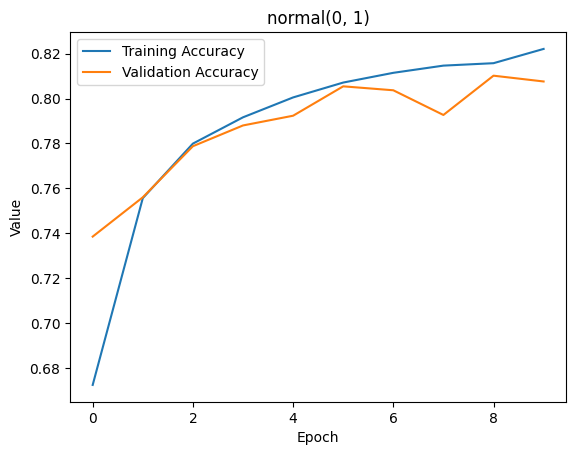

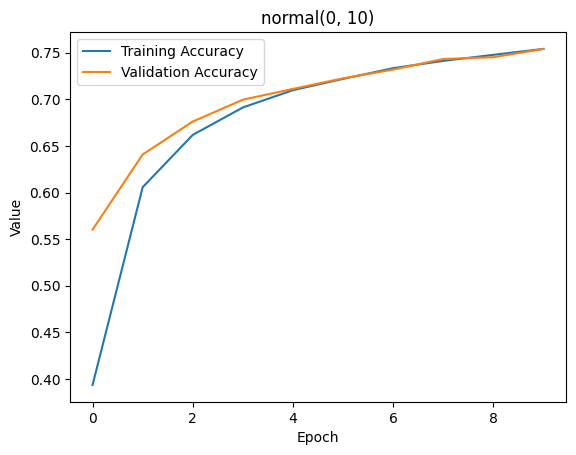

In [ ]:
for i, label in enumerate(labels):
  plt.plot(acc_test[i], label='Training Accuracy')
  plt.plot(acc_val[i], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.title(label)
  plt.legend()
  plt.show()

# Mejor modelo obtenido

Luego de prueba y error, se logró un modelo aceptable, que tiene 4 capas relu(600)-relu(416)-relu(128)-softmax(10), el uso de la técnica *ReduceLRonPlateau* produjo mejor signficativas, cuyo impacto se ve en el gráfico de accuracy vs epochs, lo cual significa que antes de aplicar la reducción, estaba oscilando de cierta manera el algoritmo. *Dropout* en cada capa fue clave también para evitar el overfitteo prematuro. No es una técnica pero el *Early Stopping* resulta infaltable para estos problemas

In [5]:
pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.4 MB/s eta 0:00:00


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 600)               471000    
                                                                 
 dropout_3 (Dropout)         (None, 600)               0         
                                                                 
 dense_5 (Dense)             (None, 416)               250016    
                                                                 
 dropout_4 (Dropout)         (None, 416)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               53376     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

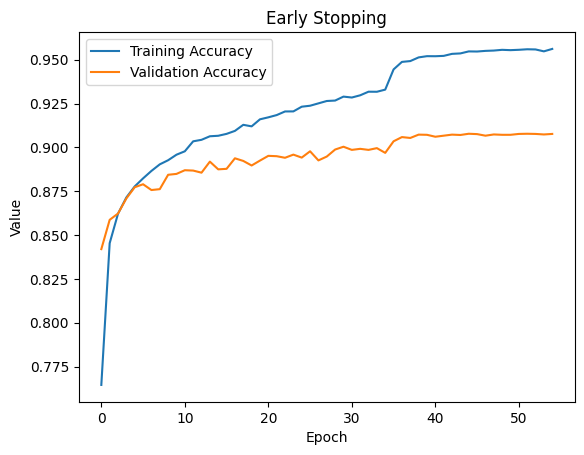

In [13]:
from tensorflow_addons.optimizers import CyclicalLearningRate, Triangular2CyclicalLearningRate, TriangularCyclicalLearningRate

np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

#clr = Triangular2CyclicalLearningRate(5e-5, 0.01, 5 * 196)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)

modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model1 = keras.models.clone_model(modelMLP)
model1.set_weights(modelMLP.get_weights())
model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)

model2 = keras.models.clone_model(modelMLP)
model2.set_weights(modelMLP.get_weights())
model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

best_model = keras.models.clone_model(modelMLP)
best_model.set_weights(modelMLP.get_weights())
best_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Early Stopping')
plt.legend()
plt.show()

Es cierto que la red hacia el final termina absurdamente overfiteada, de todas formas el test accuracy fue de los mejor obtenidos. Para seguir mejorando este modelo se podría seguir con alguna técnica de regularización mismo quizas buscando mejores valores de dropout.

# Accuracy, iteraciones vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]

Se compactan la consigna 2a y 2b en un mismo gráfico. El número de epochs no es constante, depende del Early stopping o del límite máximo establecido. 

## Accuracy vs Learning rate



Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 dense_67 (Dense)            (None, 600)               471000    
                                                                 
 dropout_21 (Dropout)        (None, 600)               0         
                                                                 
 dense_68 (Dense)            (None, 416)               250016    
                                                                 
 dropout_22 (Dropout)        (None, 416)               0         
                                                                 
 dense_69 (Dense)            (None, 128)               53376     
                                                                 
 dropout_23 (Dropout)        (None, 128)             

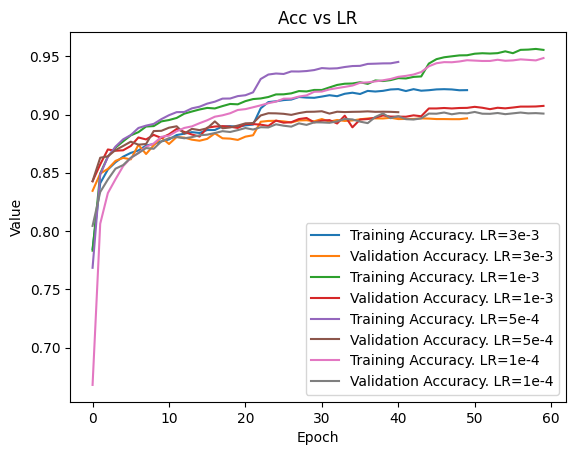

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

learning_rate_values = {'LR=3e-3':3e-3, 'LR=1e-3':1e-3, 'LR=5e-4':5e-4, 'LR=1e-4':1e-4}
train_acc_values = []
val_acc_values = []
for lr_key, lr_value in learning_rate_values.items():
  modelMLP = keras.models.clone_model(modelBase)
  modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_value), metrics=["accuracy"])

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

  history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
  train_acc_values.append(history.history['accuracy'])
  val_acc_values.append(history.history['val_accuracy'])


for (lr_key, lr_value), train_acc, val_acc in zip(learning_rate_values.items(), train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy. ' + lr_key)
  plt.plot(val_acc, label='Validation Accuracy. ' +lr_key)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs LR')
plt.legend()
plt.show()

## Accuracy vs Batch Size

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_71 (Dense)            (None, 600)               471000    
                                                                 
 dropout_24 (Dropout)        (None, 600)               0         
                                                                 
 dense_72 (Dense)            (None, 416)               250016    
                                                                 
 dropout_25 (Dropout)        (None, 416)               0         
                                                                 
 dense_73 (Dense)            (None, 128)               53376     
                                                                 
 dropout_26 (Dropout)        (None, 128)             

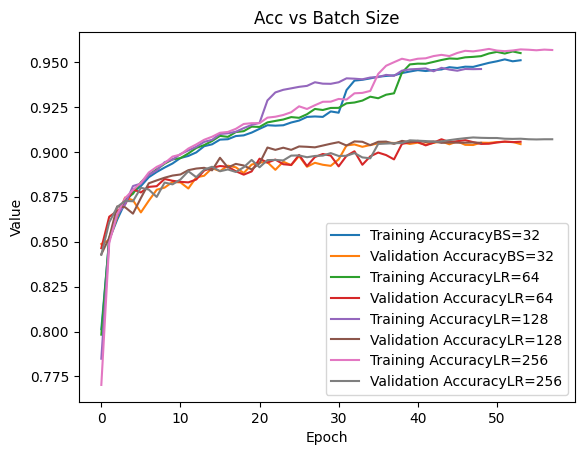

In [105]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

batch_size_values = {'BS=32':32, 'LR=64':64, 'LR=128':128, 'LR=256':256}
train_acc_values = []
val_acc_values = []
for bs_key, bs_value in batch_size_values.items():
  modelMLP = keras.models.clone_model(modelBase)
  modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

  history = modelMLP.fit(x_train_mlp, y_train, batch_size=bs_value, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
  train_acc_values.append(history.history['accuracy'])
  val_acc_values.append(history.history['val_accuracy'])


for (bs_key, bs_value), train_acc, val_acc in zip(batch_size_values.items(), train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy' + bs_key)
  plt.plot(val_acc, label='Validation Accuracy'+bs_key)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs Batch Size')
plt.legend()
plt.show()

## Accuracy vs optimizadores

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 dense_75 (Dense)            (None, 600)               471000    
                                                                 
 dropout_27 (Dropout)        (None, 600)               0         
                                                                 
 dense_76 (Dense)            (None, 416)               250016    
                                                                 
 dropout_28 (Dropout)        (None, 416)               0         
                                                                 
 dense_77 (Dense)            (None, 128)               53376     
                                                                 
 dropout_29 (Dropout)        (None, 128)             

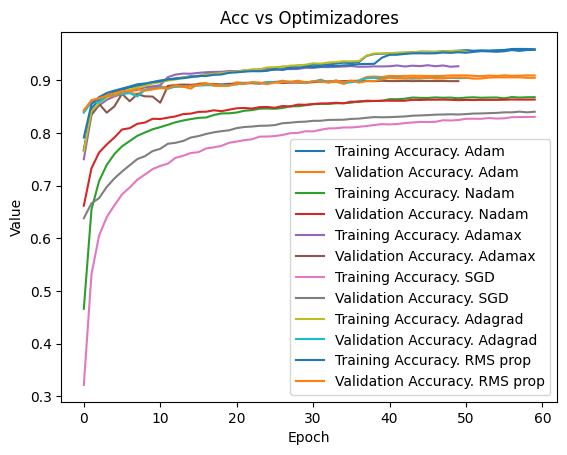

In [106]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
modelBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelBase.summary()

optimizadores = {'Adam', 'SGD', 'RMS prop', 'Adagrad', 'Adamax', 'Nadam'}
train_acc_values = []
val_acc_values = []
############### ADAM ###############
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
############### SGD ################
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.SGD(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
############### RMS prop ###########
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
############### ADAGRAD ###########
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adagrad(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
############### ADAMAX ############
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adamax(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
############### NADAM #############
modelMLP = keras.models.clone_model(modelBase)
modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Nadam(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
###################################

for optimizador_name, train_acc, val_acc in zip(optimizadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy. ' + optimizador_name)
  plt.plot(val_acc, label='Validation Accuracy. '+optimizador_name)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs Optimizadores')
plt.legend()
plt.show()

## Accuracy vs Activaciones


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 784)               0         
                                                                 
 dense_83 (Dense)            (None, 600)               471000    
                                                                 
 dropout_33 (Dropout)        (None, 600)               0         
                                                                 
 dense_84 (Dense)            (None, 416)               250016    
                                                                 
 dropout_34 (Dropout)        (None, 416)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               53376     
                                                                 
 dropout_35 (Dropout)        (None, 128)             

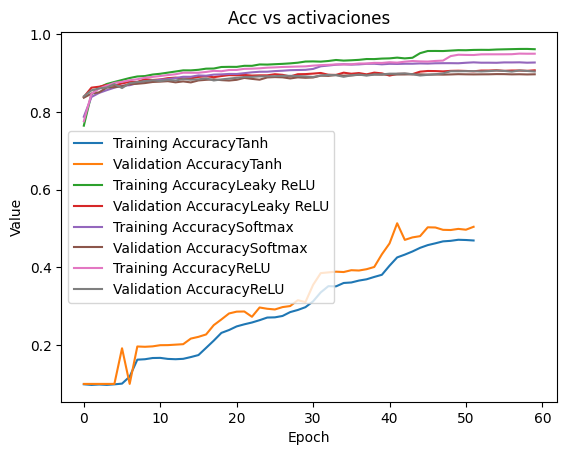

In [124]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
activaciones = {'Softmax', 'ReLU', 'Tanh', 'Leaky ReLU'}

################### SOFTMAX ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'softmax'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'softmax'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'softmax'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()
train_acc_values = []
val_acc_values = []

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### ReLU ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()


modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### Tanh ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'tanh'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'tanh'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'tanh'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()


modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### Leaky ReLU ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'leaky_relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'leaky_relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'leaky_relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])



for activacion, train_acc, val_acc in zip(activaciones, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy' + activacion)
  plt.plot(val_acc, label='Validation Accuracy'+activacion)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs activaciones')
plt.legend()
plt.show()

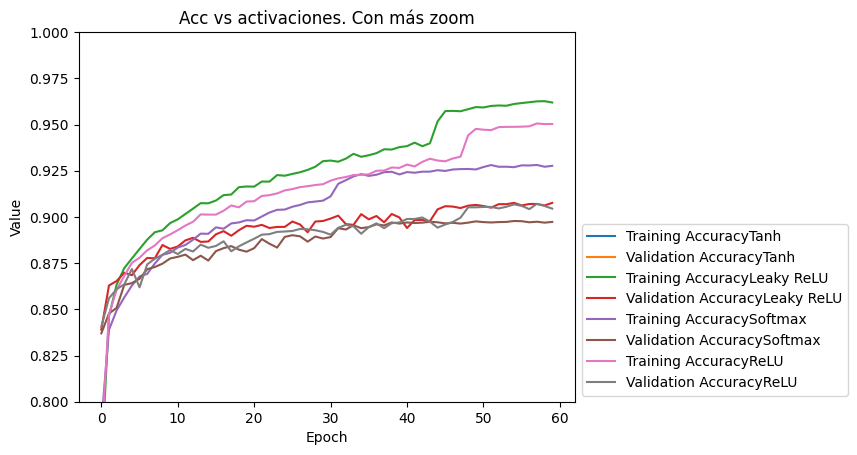

In [125]:
for activacion, train_acc, val_acc in zip(activaciones, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy' + activacion)
  plt.plot(val_acc, label='Validation Accuracy'+activacion)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0.8, 1)
plt.title('Acc vs activaciones. Con más zoom')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## Accuracy vs Dropout Rate

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 784)               0         
                                                                 
 dense_156 (Dense)           (None, 600)               471000    
                                                                 
 dropout_104 (Dropout)       (None, 600)               0         
                                                                 
 dense_157 (Dense)           (None, 416)               250016    
                                                                 
 dropout_105 (Dropout)       (None, 416)               0         
                                                                 
 dense_158 (Dense)           (None, 128)               53376     
                                                                 
 dropout_106 (Dropout)       (None, 128)             

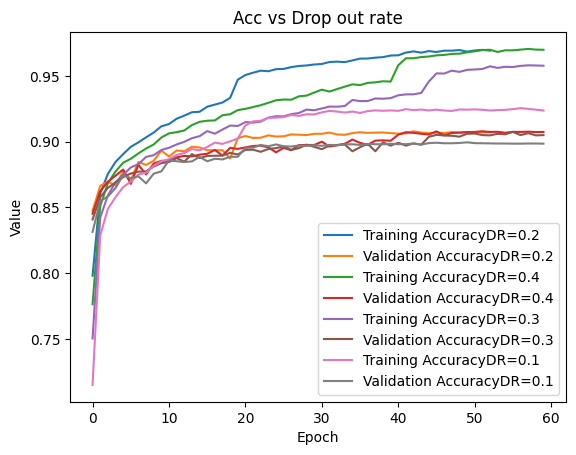

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
drates = {'DR=0.1', 'DR=0.2', 'DR=0.3', 'DR=0.4'}

################### SOFTMAX ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()
train_acc_values = []
val_acc_values = []

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### ReLU ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### Tanh ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### Leaky ReLU ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.4),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])

for drate, train_acc, val_acc in zip(drates, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy' + drate)
  plt.plot(val_acc, label='Validation Accuracy'+drate)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs Drop out rate')
plt.legend()
plt.show()

## Accuracy vs Batch Normalization

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_45 (Flatten)        (None, 784)               0         
                                                                 
 dense_172 (Dense)           (None, 600)               471000    
                                                                 
 dropout_116 (Dropout)       (None, 600)               0         
                                                                 
 dense_173 (Dense)           (None, 416)               250016    
                                                                 
 dropout_117 (Dropout)       (None, 416)               0         
                                                                 
 dense_174 (Dense)           (None, 128)               53376     
                                                                 
 dropout_118 (Dropout)       (None, 128)             

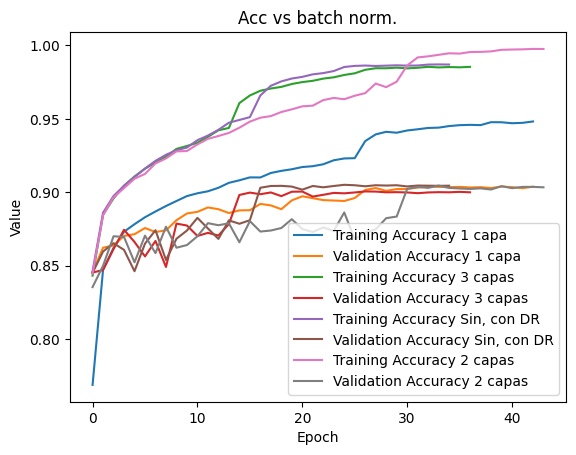

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
batchNorm = {'Sin, con DR', '1 capa', '2 capas', '3 capas'}

################### Solo con DR ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()
train_acc_values = []
val_acc_values = []

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### Sin DR, 1 capa ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(416, activation = 'relu'),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### 2 capas ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(416, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### 3 capas ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(416, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])



for batchN, train_acc, val_acc in zip(batchNorm, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy ' + batchN)
  plt.plot(val_acc, label='Validation Accuracy '+batchN)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs batch norm.')
plt.legend()
plt.show()

## Accuracy vs Inicializadores de peso

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_49 (Flatten)        (None, 784)               0         
                                                                 
 dense_188 (Dense)           (None, 600)               471000    
                                                                 
 dropout_119 (Dropout)       (None, 600)               0         
                                                                 
 dense_189 (Dense)           (None, 416)               250016    
                                                                 
 dropout_120 (Dropout)       (None, 416)               0         
                                                                 
 dense_190 (Dense)           (None, 128)               53376     
                                                                 
 dropout_121 (Dropout)       (None, 128)             

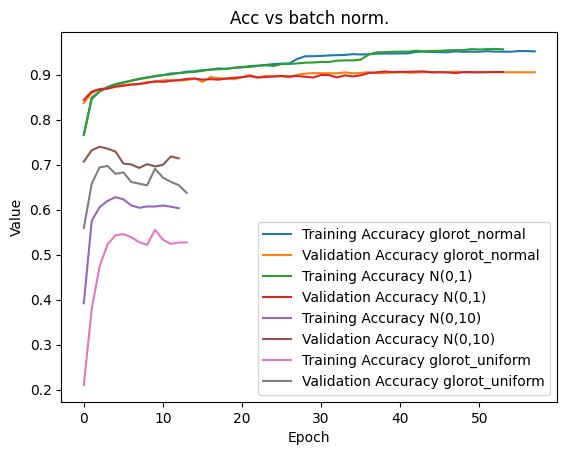

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
inicializadores = {'glorot_uniform', 'glorot_normal', 'N(0,1)', 'N(0,10)'}

################### glorot uniform ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu', kernel_initializer = 'glorot_uniform'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu', kernel_initializer = 'glorot_uniform'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax', kernel_initializer = 'glorot_uniform')
    ]
)
modelMLP.summary()
train_acc_values = []
val_acc_values = []

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### glorot normal ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu', kernel_initializer = 'glorot_normal'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu', kernel_initializer = 'glorot_normal'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_normal'),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### N(0,1) ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu',kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu', kernel_initializer =keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu', kernel_initializer =keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])
################### N(0, 10) ##########################
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu', kernel_initializer =keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu',kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu',kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dropout(0.2),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])
train_acc_values.append(history.history['accuracy'])
val_acc_values.append(history.history['val_accuracy'])

for inicializador, train_acc, val_acc in zip(inicializadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training Accuracy ' + inicializador)
  plt.plot(val_acc, label='Validation Accuracy '+ inicializador)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Acc vs batch norm.')
plt.legend()
plt.show()

# Lottery Golden Ticket

## Buscando los pesos que menos cambiaron




In [13]:
model1_weights = model1.get_weights()
model2_weights = model2.get_weights()

model3 = keras.models.clone_model(model1)
weights2delete = []
i = 0
for layer2_weights in model2_weights:
  if (i % 2) == 0:
    flattened_matrix = layer2_weights.flatten()

    sorted_indices = np.argsort(flattened_matrix)

    num_elements = int(len(flattened_matrix) * 0.5)

    smallest_indexes = sorted_indices[:num_elements]

    row_indexes, col_indexes = np.unravel_index(smallest_indexes, layer2_weights.shape)
    fancy_index = (row_indexes, col_indexes)
    weights2delete.append(fancy_index)
  else:
    weights2delete.append(None)
  i = i + 1


## Ahora entrenamos la red 3 borrando los pesos useless en cada batch

Se define una callback a la cual se llama cada vez que entrena una batch para setear en 0 los pesos que molestan

In [84]:
class CustomCallback(keras.callbacks.Callback):
  def on_train_batch_begin(self, batch, logs = None):
    keys = list(logs.keys())
    model3_weights = model3.get_weights()
    i=0
    new_weights = []
    for weights2zero, layer in zip(weights2delete, model3_weights):
      if (i%2) == 0:
        layer[weights2zero] = 0
        new_weights.append(layer)
      else:
        new_weights.append(layer)
      i = i + 1
    model3.set_weights(new_weights)
model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-6, patience=5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model3.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, CustomCallback(), reduce_lr])

test_loss, test_acc = model3.evaluate(x_test_mlp, y_test, verbose=2)
print("Model 3 Test accuracy:", test_acc)

Epoch 1/60
  4/235 [..............................] - ETA: 4s - loss: 0.1813 - accuracy: 0.9365  

235/235 [==============================] - 7s 23ms/step - loss: 0.1877 - accuracy: 0.9295 - val_loss: 0.3138 - val_accuracy: 0.8927 - lr: 5.0000e-04
Epoch 2/60
235/235 [==============================] - 5s 20ms/step - loss: 0.1846 - accuracy: 0.9313 - val_loss: 0.3072 - val_accuracy: 0.8957 - lr: 5.0000e-04
Epoch 3/60
235/235 [==============================] - 4s 17ms/step - loss: 0.1815 - accuracy: 0.9317 - val_loss: 0.3133 - val_accuracy: 0.8969 - lr: 5.0000e-04
Epoch 4/60
235/235 [==============================] - 4s 17ms/step - loss: 0.1784 - accuracy: 0.9334 - val_loss: 0.3252 - val_accuracy: 0.8934 - lr: 5.0000e-04
Epoch 5/60
235/235 [==============================] - 6s 24ms/step - loss: 0.1750 - accuracy: 0.9347 - val_loss: 0.3041 - val_accuracy: 0.8990 - lr: 5.0000e-04
Epoch 6/60
235/235 [==============================] - 4s 18ms/step - loss: 0.1718 - accuracy: 0.9358 - val_loss: 0.3163 - val_accuracy: 0.8973 - lr: 5.0000e-04
Epoch 7/60
235/235 [==============================]

In [75]:
test_loss, test_acc = best_model.evaluate(x_test_mlp, y_test, verbose=2)
print("Model 2 Test accuracy:", test_acc)

313/313 - 1s - loss: 0.3462 - accuracy: 0.9040 - 1s/epoch - 4ms/step
Model 2 Test accuracy: 0.9039999842643738


# Métricas 

Curva ROC, área bajo la curva ROC, F1-score, Precisión y
Recall. Enunciar para el F1-score y el área bajo la curva ROC.

Se utilizó el micro average, ya que a diferencia del macro average, que normaliza las métricas de cada clase y despues toma un promedio de todo, micro average hace lo contrario por lo que si las clases están balanceadas, las clases con más cantidad de elementos impactarán más en la métrica

## Matriz de confusión

Permite ver que tan bien performa el clasificador según la clase.

313/313 [==============================] - 1s 3ms/step
Precision: 0.9078
Recall: 0.9078
F1-score: 0.9078


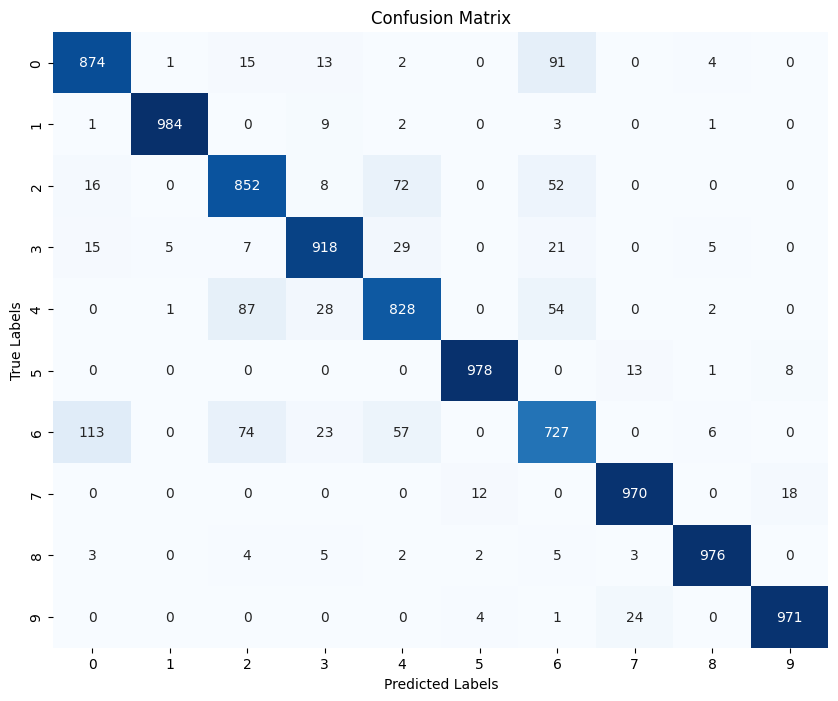

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = best_model.predict(x_test_mlp)
y_pred = np.argmax(y_pred, axis=1)

precision, recall, f1score, _ = precision_recall_fscore_support( y_test, y_pred, average='micro')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1score))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


*Notamos que lo que mas confunde son las T-shirt con las Shirt, lo cual tiene sentido dado su parecido*



313/313 [==============================] - 1s 3ms/step


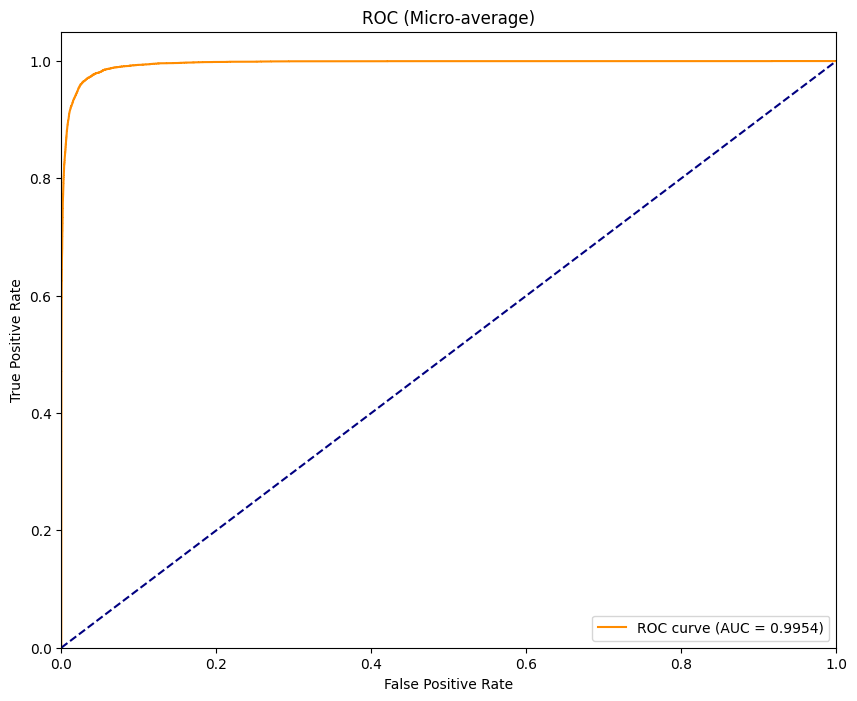

In [15]:
from sklearn.metrics import roc_curve, auc

y_pred =  best_model.predict(x_test_mlp)

n_classes = y_pred.shape[1]

y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=n_classes)

fpr, tpr, thresholds = roc_curve(y_test_one_hot.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Micro-average)')
plt.legend(loc="lower right")
plt.show()

# Clusterización

In [16]:
modelMLP = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(600, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(416, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(2, activation = 'linear'),
        layers.Dense(10, activation = 'softmax')
    ]
)
modelMLP.summary()

modelMLP.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = modelMLP.fit(x_train_mlp, y_train, batch_size=256, epochs=60, validation_data = (x_test_mlp, y_test), callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = modelMLP.evaluate(x_test_mlp, y_test, verbose=2)
print("Test accuracy:", test_acc)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 600)               471000    
                                                                 
 dropout_6 (Dropout)         (None, 600)               0         
                                                                 
 dense_9 (Dense)             (None, 416)               250016    
                                                                 
 dropout_7 (Dropout)         (None, 416)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               53376     
                                                                 
 dense_11 (Dense)            (None, 2)                

In [17]:
import numpy as np

model2neurons = keras.Model(inputs=modelMLP.input, outputs=modelMLP.layers[-2].output)

test2dpoints = model2neurons.predict(x_test_mlp)

predictionsTest = modelMLP.predict(x_test_mlp)

classIndex = np.argmax(predictionsTest, axis = 1)

classIndex = y_test

313/313 [==============================] - 2s 6ms/step


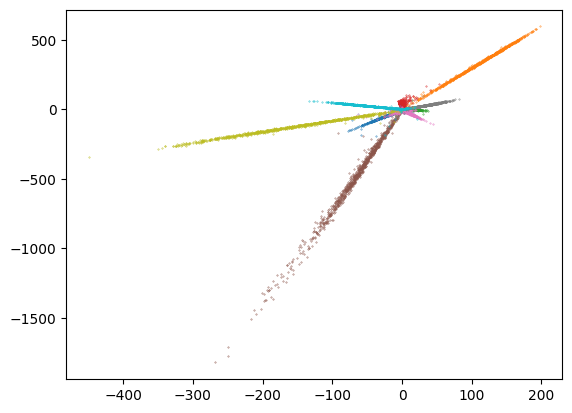

In [18]:

classPoints = []
for i in range(0, 10):
  classPoints.append(test2dpoints[np.where(classIndex == i)])

for points in classPoints:
  plt.scatter(points[:, 0], points[:, 1], label='Scatter Points', s = 0.1)


(40000, 2)
1250/1250 [==============================] - 3s 2ms/step


<ipython-input-45-902680bd3d35>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatters = plt.scatter(points[:, 0], points[:, 1] ,s = 0.1, cmap='tab10')


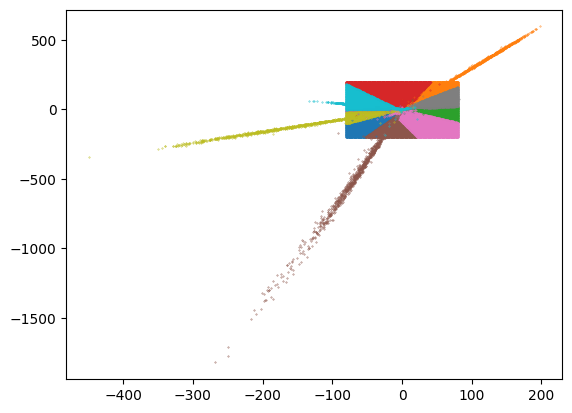

In [45]:
num_points = 200

x_values = np.linspace(-80, 80, num_points)
y_values = np.linspace(-200, 200, num_points)

x_grid, y_grid = np.meshgrid(x_values, y_values)

pointsGrid = np.vstack((x_grid.flatten(), y_grid.flatten())).T

print(pointsGrid.shape)


modelOutput = keras.Model(inputs=modelMLP.layers[-2].output, outputs=modelMLP.output)
predictionsGrid = modelOutput.predict(pointsGrid)

classGridIndex = np.argmax(predictionsGrid, axis = 1)

classGridPoints = []
for i in range(0, 10):
  classGridPoints.append(pointsGrid[np.where(classGridIndex == i)])

class_labels = [
                "T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"
                ]
color_map = plt.cm.tab10
for i, points in enumerate(classGridPoints):
  scatters = plt.scatter(points[:, 0], points[:, 1] ,s = 0.1, cmap='tab10')
for points in classPoints:
  plt.scatter(points[:, 0], points[:, 1], s = 0.1)


<Figure size 3000x3000 with 0 Axes>

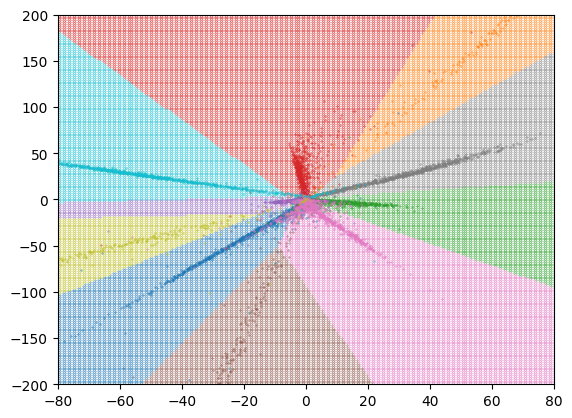

<Figure size 3000x3000 with 0 Axes>

In [56]:
for i, points in enumerate(classGridPoints):
  plt.scatter(points[:, 0], points[:, 1] ,s = 0.1)
for i, points in enumerate(classPoints):
  scatters = plt.scatter(points[:, 0], points[:, 1], s = 0.1)

#plt.colorbar(scatters).set_ticklabels(class_labels)
plt.ylim(-200, 200) 
plt.xlim(-80, 80) 
plt.figure(figsize=(30, 30)) 


# Problema de Regresión

In [57]:
from tensorflow.keras.datasets import mnist
import pandas as pd
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("/train-morpho.csv")
test_morpho = pd.read_csv("/t10k-morpho.csv")

11490434/11490434 [==============================] - 0s 0us/step


In [58]:
df = pd.read_csv("/train-morpho.csv")


# EDA

In [6]:
df.head()

index      area     length  thickness     slant      width     height
0      0  107.3125  50.266504   2.460658  0.231074  14.539572  19.849054
1      1  123.2500  51.198485   2.616601  0.331858  15.387810  19.341053
2      2   78.3750  45.927670   1.891592 -0.212196  20.479656  19.114880
3      3   67.3125  22.849242   2.919769  0.509185   5.358179  19.724599
4      4   91.1875  46.284271   2.247425  0.007590  13.275437  19.527523

pandas.core.frame.DataFrame

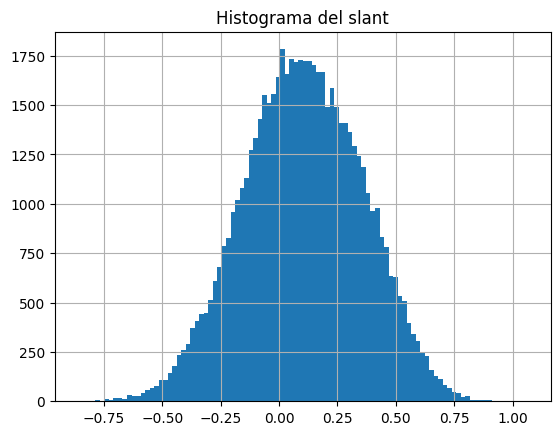

In [ ]:
df.slant.hist(bins = 100)
plt.title("Histograma del slant")

type(df)

<Axes: >

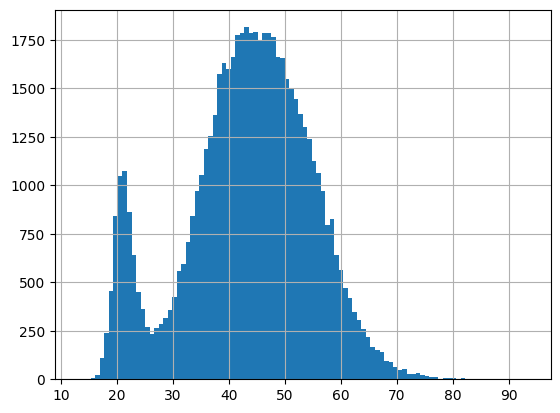

In [ ]:
df.length.hist(bins = 100)
plt.title("Histograma del largo")

Text(0.5, 1.0, 'Histograma del ancho')

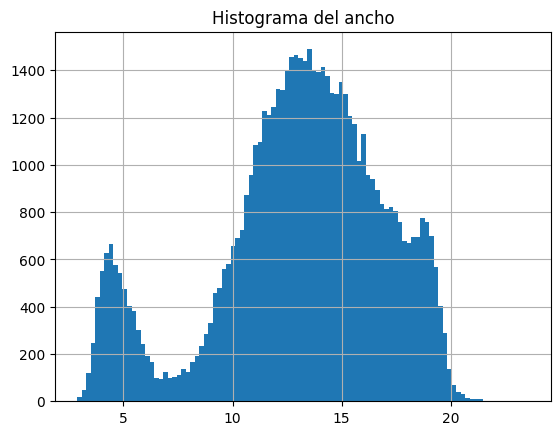

In [ ]:
df.width.hist(bins = 100)
plt.title("Histograma del ancho")

Text(0.5, 1.0, 'Histograma de la altura')

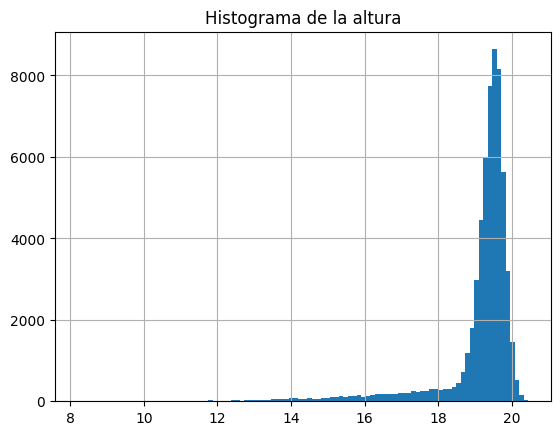

In [ ]:
df.height.hist(bins = 100)
plt.title("Histograma de la altura")

In [59]:
df2 = pd.read_csv("/t10k-morpho.csv")

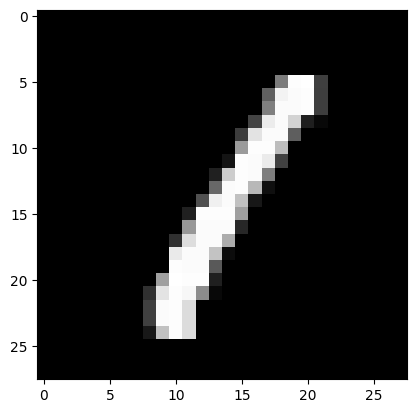

In [ ]:
plt.imshow(x_train[3], cmap = 'gray')

# Análisis de correlaciones

Text(0.5, 1.0, 'height vs slant')

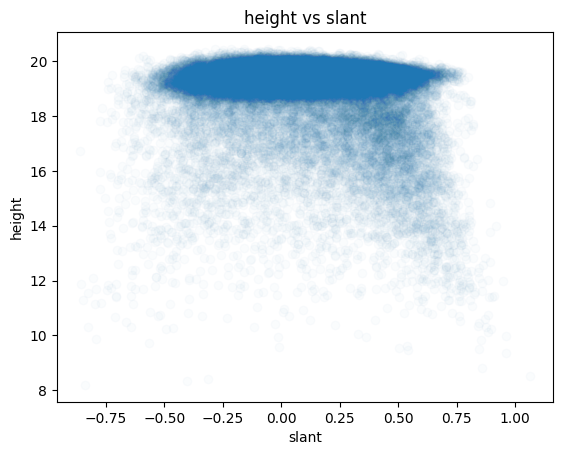

In [8]:
plt.scatter(df.slant, df.height, alpha = 0.02)
plt.xlabel('slant')
plt.ylabel('height')
plt.title('height vs slant')

Text(0.5, 1.0, 'thickness vs slant')

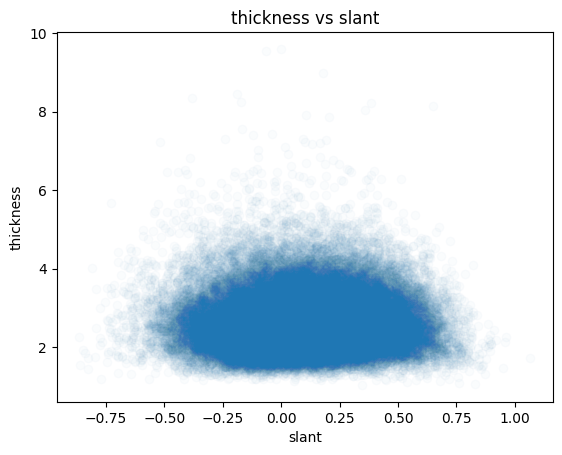

In [ ]:
plt.scatter(df.slant, df.thickness, alpha = 0.02)
plt.xlabel('slant')
plt.ylabel('thickness')
plt.title('thickness vs slant')

Text(0.5, 1.0, 'anotaciones vs slant')

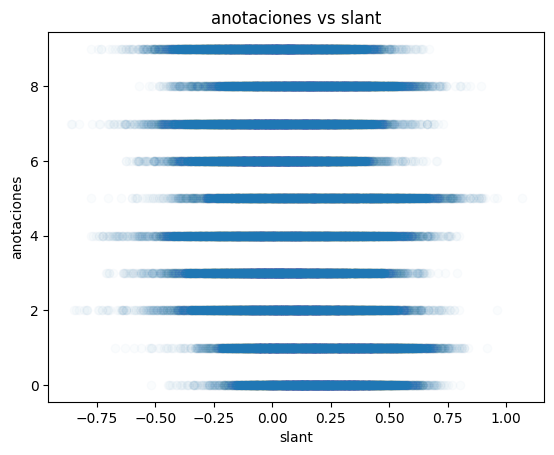

In [ ]:
plt.scatter(df.slant, y_train, alpha = 0.02)
plt.xlabel('slant')
plt.ylabel('anotaciones')
plt.title('anotaciones vs slant')

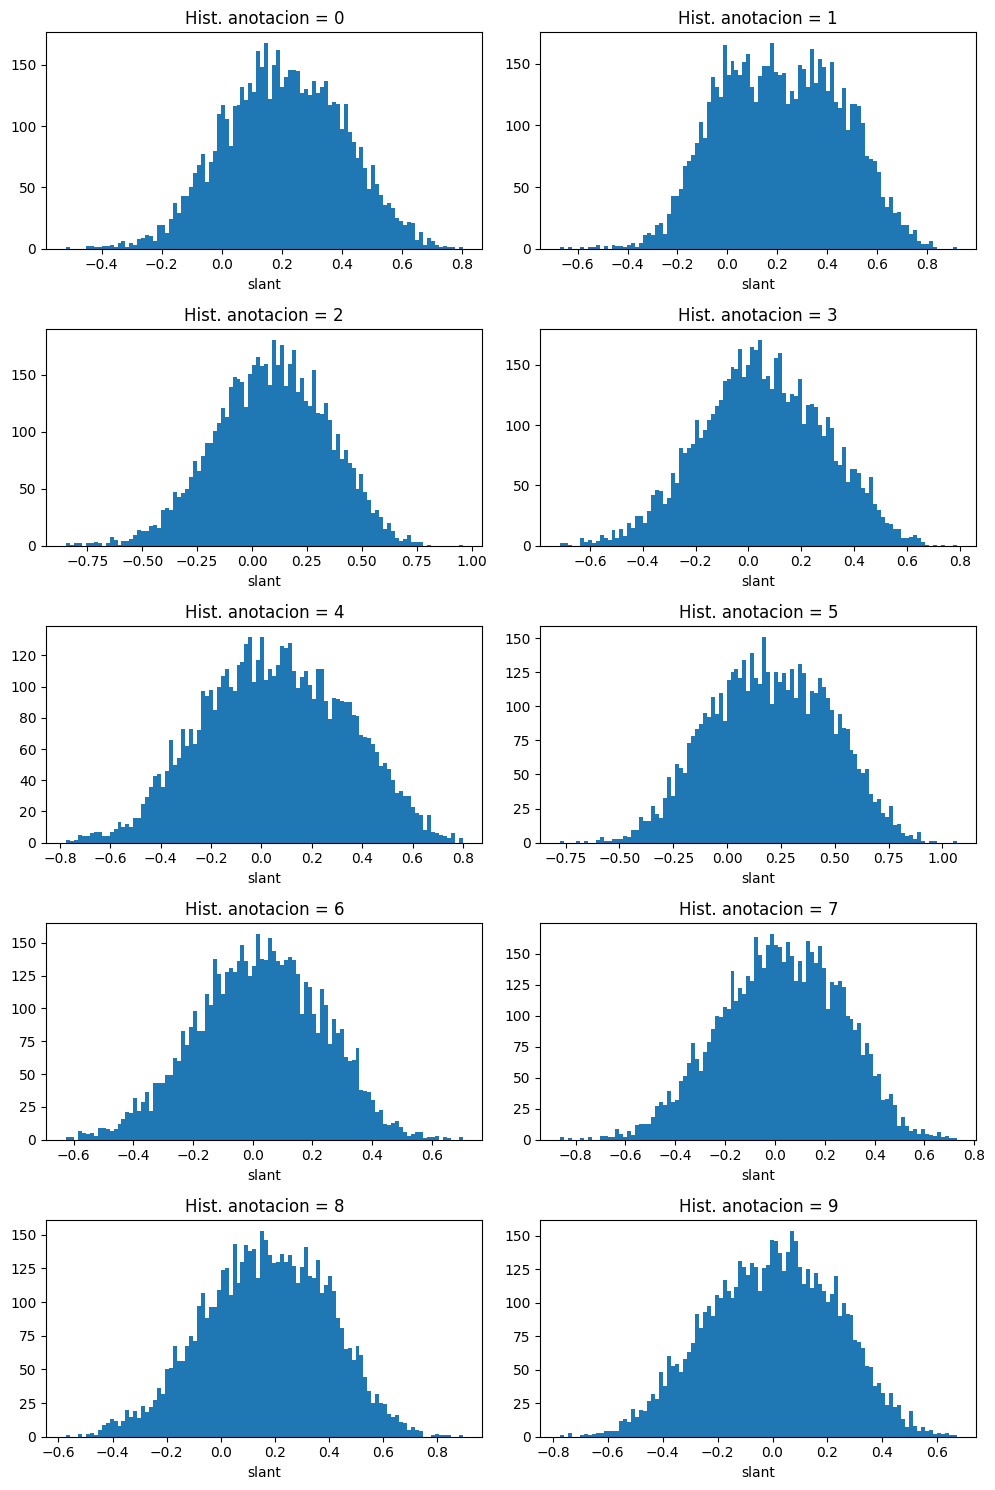

In [10]:
slants = []
for i in range(0, 10):
  slants.append(np.array(df['slant'])[y_train == i])

fig, axs = plt.subplots(5, 2, figsize=(10, 15))
titles = ['Hist. anotacion = 0', 'Hist. anotacion = 1', 'Hist. anotacion = 2', 'Hist. anotacion = 3', 'Hist. anotacion = 4', 
          'Hist. anotacion = 5', 'Hist. anotacion = 6', 'Hist. anotacion = 7', 'Hist. anotacion = 8', 'Hist. anotacion = 9']
k = 0;
for i in range(5):
    for j in range(2):
        axs[i, j].hist(slants[k], bins = 100)
        axs[i, j].set_title(titles[k])
        axs[i, j].set_xlabel('slant')
        k = k + 1
plt.tight_layout()

plt.show()

En los histogramas anotaciones vs slant, podemos notar que si supiesemos la anotación antes de entrar a la red, nos aportaría información sobre el slant, en el itema b esto es probado

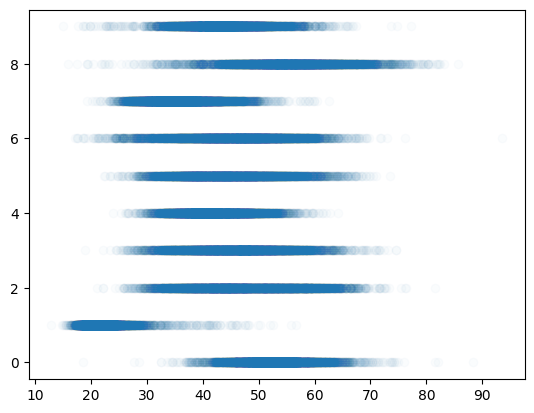

In [ ]:
plt.scatter(df.length, y_train, alpha = 0.02)

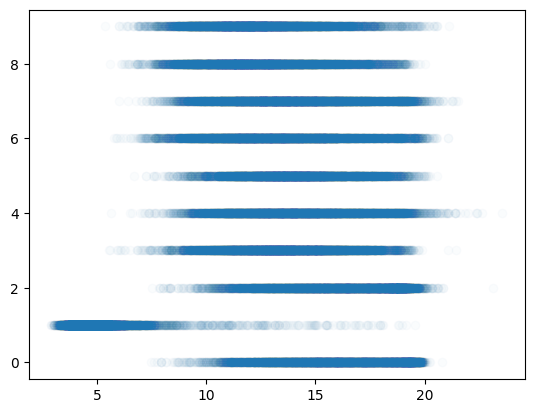

In [ ]:
plt.scatter(df.width, y_train, alpha = 0.02)

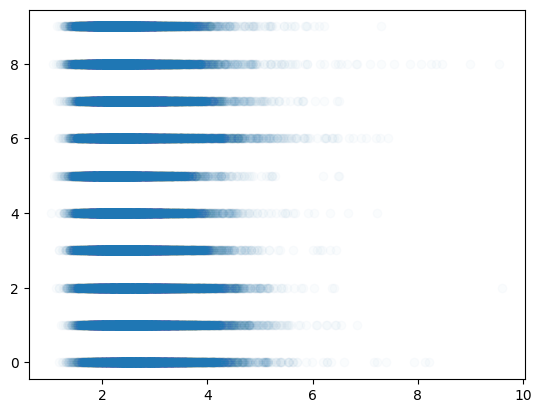

In [ ]:
plt.scatter(df.thickness, y_train, alpha = 0.02)

En estas observaciones, de anotación vs length, width, thickness, notamos particularmente para los dos primeras, que saber el width y length, nos aporta información a la hora de dicernir sobre que anotación estamos, si bien a priori no parece ser de interés, como vimos anteriormente que si se la anotación tengo información sobre el slant, entonces poder tener una estimación de la categoría a través de una variable continua intuitivamente tiene que ayudar a que se obtenga un slant mas preciso.


## MLP

In [60]:
x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]

modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               100480    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________


In [61]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])

mae_test = modelRegresion.evaluate(x_test_reg, y_test_slants, verbose=2)
print("Test mae:", mae_test)


Epoch 1/60
235/235 [==============================] - 5s 13ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - lr: 0.0010
Epoch 2/60
235/235 [==============================] - 2s 10ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181 - lr: 0.0010
Epoch 3/60
235/235 [==============================] - 4s 15ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174 - lr: 0.0010
Epoch 4/60
235/235 [==============================] - 3s 13ms/step - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136 - lr: 0.0010
Epoch 5/60
235/235 [==============================] - 3s 12ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127 - lr: 0.0010
Epoch 6/60
235/235 [==============================] - 3s 12ms/step - loss: 0.0115 - mean_absolute_error: 0.011

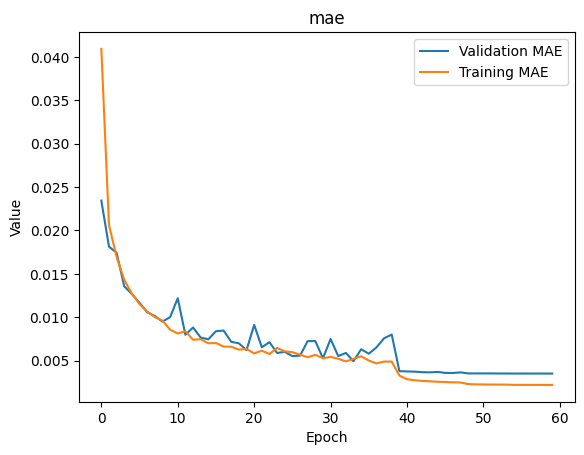

In [62]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('mae')
plt.legend()
plt.show()

## MLP pero ahora con Embeddings de tamaño **2**

In [70]:
x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]

input_img = keras.Input((28, 28))
input_lbl = keras.Input(1,)
flatten = keras.layers.Flatten()(input_img)
embed = keras.layers.Embedding(10, 2, input_length=1)(input_lbl)
embed = keras.layers.Flatten()(embed)
concat = keras.layers.Concatenate()([flatten, embed])
dense = keras.layers.Dense(128, activation='relu')(concat)
dense = keras.layers.Dense(64, activation='relu')(dense)

out = keras.layers.Dense(1, activation = 'linear')(dense)

modelRegresion = keras.Model([input_img, input_lbl], out)

modelRegresion.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 2)         20          ['input_15[0][0]']               
                                                                                                  
 flatten_8 (Flatten)            (None, 784)          0           ['input_14[0][0]']               
                                                                                            

In [71]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit([x_train_reg, y_train], y_train_slants, batch_size=256, epochs=60, validation_data = ([x_test_reg, y_test], y_test_slants), callbacks = [reduce_lr, early_stopping])

mae_test = modelRegresion.evaluate([x_test_reg, y_test], y_test_slants, verbose=2)
print("mae Test:", mae_test)

Epoch 1/60
235/235 [==============================] - 4s 12ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - lr: 0.0010
Epoch 2/60
235/235 [==============================] - 3s 12ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178 - lr: 0.0010
Epoch 3/60
235/235 [==============================] - 2s 10ms/step - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0140 - val_mean_absolute_error: 0.0140 - lr: 0.0010
Epoch 4/60
235/235 [==============================] - 2s 9ms/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123 - lr: 0.0010
Epoch 5/60
235/235 [==============================] - 2s 9ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112 - lr: 0.0010
Epoch 6/60
235/235 [==============================] - 2s 9ms/step - loss: 0.0105 - mean_absolute_error: 0.0105 -

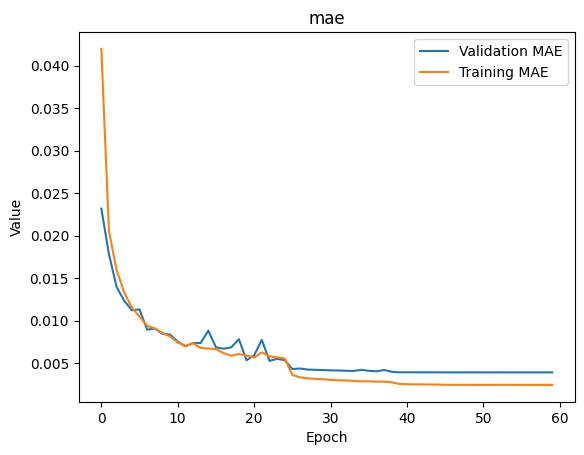

In [72]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('mae')
plt.legend()
plt.show()

## Gráfico de Embeddings

In [49]:
layer = modelRegresion.get_layer('embedding_3')
weights = layer.get_weights()

for layer_weights in weights:
    print(layer_weights)

new_model = keras.Sequential()
new_model.add(layer)

new_model.set_weights(weights)
a = np.array([9])
predictions = new_model.predict(a)

print(predictions)
# Cada fila de la matriz, es el vector de embedding asociado a cada número de la categórica


[[-0.25194165  0.23601738]
 [-0.21565495  0.20871136]
 [-0.32723704  0.15592776]
 [-0.30409268  0.18841141]
 [-0.31419224  0.13631678]
 [-0.27664337  0.23024595]
 [-0.2857708   0.18256183]
 [-0.31981945  0.1347562 ]
 [-0.2991541   0.19786604]
 [-0.30314475  0.15956911]]
1/1 [==============================] - 0s 77ms/step
[[[-0.30314475  0.15956911]]]


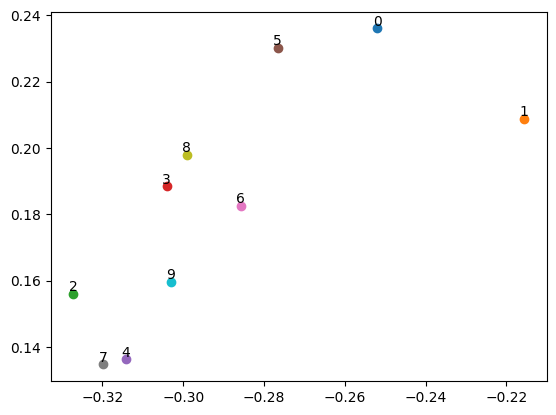

In [50]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(weights[0].shape[0]):
    row = weights[0][i]
    plt.scatter(row[0], row[1])
    plt.text(row[0], row[1], labels[i], ha='center', va='bottom')

Se ve como los números mas parecidos quedan mas cerca, como el 4 y 7 que son muy similares, o el 3 y el 8. 

## Con una variable continua

De entre las variables continuas se busco aquella que tenga una mayor covarianza, puede que no sea el criterio óptimo pero al menos es un criterio.

In [52]:
aux = np.hstack((np.array(df.width[0:1000]).reshape(-1, 1), np.array(df.slant[0:1000]).reshape(-1, 1)))
cov_matrix = np.cov(aux, rowvar=False)

print("Covariance Matrix WIDTH:")
print(cov_matrix)



Covariance Matrix WIDTH:
[[14.40885011 -0.17544018]
 [-0.17544018  0.07408343]]


In [53]:
aux = np.hstack((np.array(df.length[0:1000]).reshape(-1, 1), np.array(df.slant[0:1000]).reshape(-1, 1)))
cov_matrix = np.cov(aux, rowvar=False)

print("Covariance Matrix LENGTH:")
print(cov_matrix)


Covariance Matrix LENGTH:
[[1.15865112e+02 2.51345290e-02]
 [2.51345290e-02 7.40834333e-02]]


In [54]:
aux = np.hstack((np.array(df.thickness[0:1000]).reshape(-1, 1), np.array(df.slant[0:1000]).reshape(-1, 1)))
cov_matrix = np.cov(aux, rowvar=False)

print("Covariance Matrix:")
print(cov_matrix)


Covariance Matrix:
[[0.33505513 0.00696216]
 [0.00696216 0.07408343]]


In [73]:
x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]

x_train_width = (np.array(df['width']) - np.mean(np.array(df['width'])) )/np.std(np.array(df['width']))
x_test_width =  (np.array(df2['width']) - np.mean(np.array(df2['width'])) )/np.std(np.array(df2['width']))

input_img = keras.Input((28, 28))
widthIn = keras.Input(1,)
flatten = keras.layers.Flatten()(input_img)
concat = keras.layers.Concatenate()([flatten, widthIn])
dense = keras.layers.Dense(128, activation='relu')(concat)
dense = keras.layers.Dense(64, activation='relu')(dense)

out = keras.layers.Dense(1, activation = 'linear')(dense)

modelRegresion = keras.Model([input_img, widthIn], out)

modelRegresion.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mae')
modelRegresion.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 784)          0           ['input_16[0][0]']               
                                                                                                  
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 785)          0           ['flatten_10[0][0]',             
                                                                  'input_17[0][0]']         

In [74]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit([x_train_reg, x_train_width], y_train_slants, batch_size=256, epochs=60, validation_data = ([x_test_reg, x_test_width], y_test_slants), callbacks = [early_stopping, reduce_lr])

mae_test = modelRegresion.evaluate([x_test_reg, x_test_width], y_test_slants, verbose=2)
print("Test mae:", mae_test)

Epoch 1/60
235/235 [==============================] - 3s 11ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245 - lr: 0.0010
Epoch 2/60
235/235 [==============================] - 2s 10ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177 - lr: 0.0010
Epoch 3/60
235/235 [==============================] - 2s 7ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148 - lr: 0.0010
Epoch 4/60
235/235 [==============================] - 2s 7ms/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128 - lr: 0.0010
Epoch 5/60
235/235 [==============================] - 2s 7ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116 - lr: 0.0010
Epoch 6/60
235/235 [==============================] - 2s 8ms/step - loss: 0.0105 - mean_absolute_error: 0.0105 - 

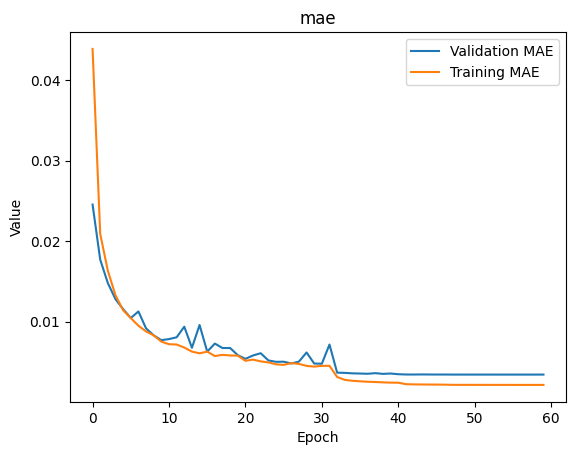

In [75]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('mae')
plt.legend()
plt.show()

Resulta increible pero el MAE mejoró levemente para cuando se agrego el width a la entrada pero **empeoró** con la anotación en la entrada. De todas formas, anteriormente se realizó un entrenamiento con una cantidad de epochs baja, de 10, y en ese caso si mostraba una mejora.

# MAE vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]


Para la misma cantidad de **epochs**, se evaluara lo mencionado anteriormente

## MAE vs Learning rate


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               100480    
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
235/235 [==============================] - 3s 8ms/step - loss: 0.0519 - mean_absolute_error: 0.0519 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267 - lr: 0.0030
Epo

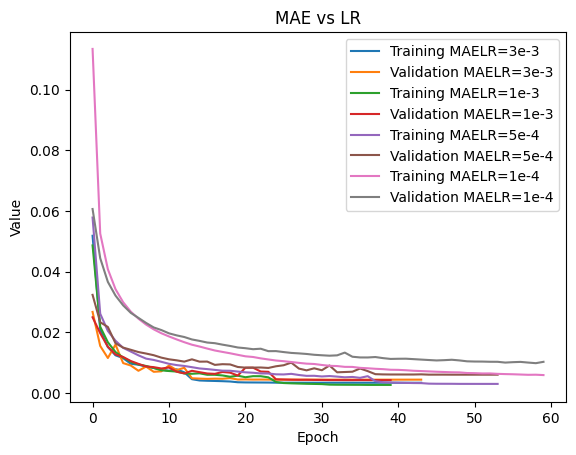

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=4)
modelRegresionBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresionBase.summary()

learning_rate_values = {'LR=3e-3':3e-3, 'LR=1e-3':1e-3, 'LR=5e-4':5e-4, 'LR=1e-4':1e-4}
train_acc_values = []
val_acc_values = []

for lr_key, lr_value in learning_rate_values.items():
  modelRegresion = keras.models.clone_model(modelRegresionBase)
  modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=lr_value), metrics=["mean_absolute_error"])
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
  train_acc_values.append(history.history['mean_absolute_error'])
  val_acc_values.append(history.history['val_mean_absolute_error'])

for (lr_key, lr_value), train_acc, val_acc in zip(learning_rate_values.items(), train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training MAE' + lr_key)
  plt.plot(val_acc, label='Validation MAE'+lr_key)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs LR')
plt.legend()
plt.show()

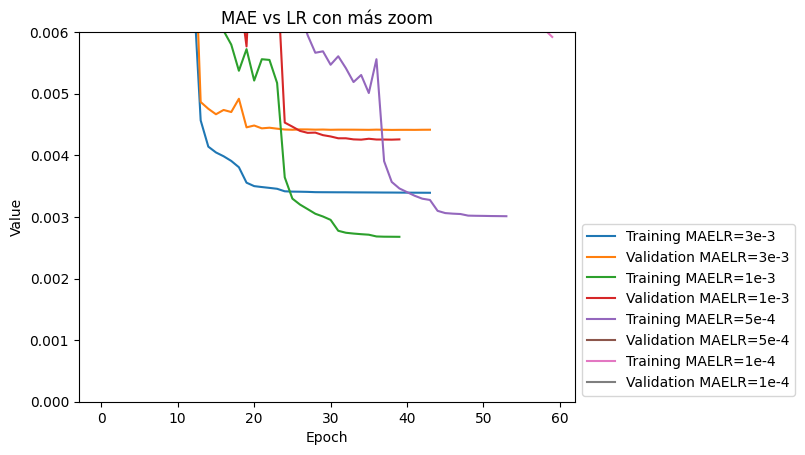

In [67]:
for (lr_key, lr_value), train_acc, val_acc in zip(learning_rate_values.items(), train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training MAE' + lr_key)
  plt.plot(val_acc, label='Validation MAE'+lr_key)

plt.ylim(0, 0.006)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs LR con más zoom')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## MAE vs Batch Size

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               100480    
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
938/938 [==============================] - 3s 3ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229 - lr: 0.0010
Epo

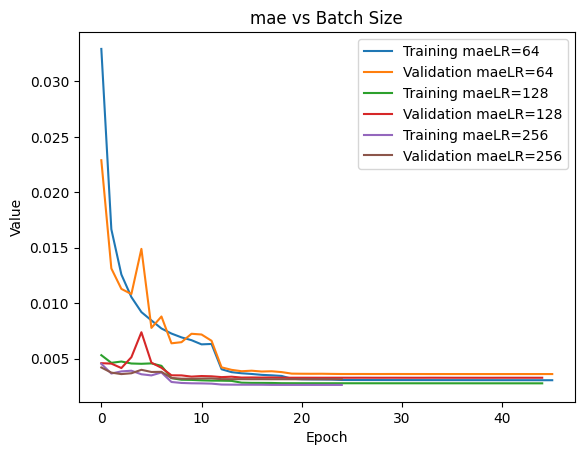

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=4)
modelRegresionBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresionBase.summary()

batch_size_values = {'LR=64':64, 'LR=128':128, 'LR=256':256}
train_acc_values = []
val_acc_values = []
for bs_key, bs_value in batch_size_values.items():
  modelRegresion = keras.models.clone_model(modelRegresionBase)
  modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=bs_value, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
  train_acc_values.append(history.history['mean_absolute_error'])
  val_acc_values.append(history.history['val_mean_absolute_error'])


for (bs_key, bs_value), train_acc, val_acc in zip(batch_size_values.items(), train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae' + bs_key)
  plt.plot(val_acc, label='Validation mae'+bs_key)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('mae vs Batch Size')
plt.legend()
plt.show()

## MAE vs optimizadores

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               100480    
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
235/235 [==============================] - 3s 8ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - lr: 0.0010
Epo

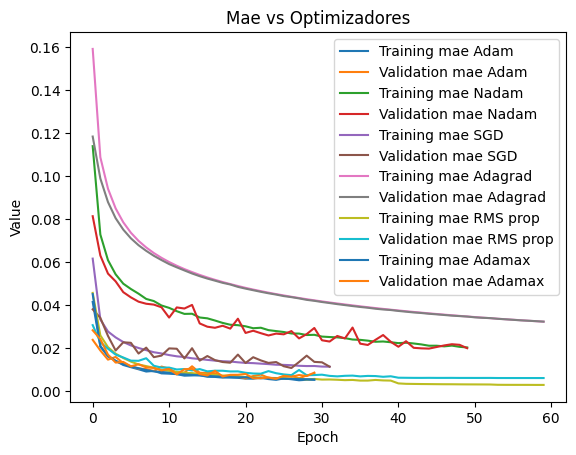

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_reg = x_train.astype("float32") / 255.0
x_test_reg = x_test.astype("float32") / 255.0

y_train_slants = df["slant"]
y_test_slants = df2["slant"]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.1, min_lr=1e-6, patience=4)
modelRegresionBase = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresionBase.summary()

optimizadores = {'Adam', 'SGD', 'RMS prop', 'Adagrad', 'Adamax', 'Nadam'}
train_acc_values = []
val_acc_values = []
############### ADAM ###############
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
############### SGD ################
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.SGD(), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
############### RMS prop ###########
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.RMSprop(), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
############### ADAGRAD ###########
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adagrad(), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
############### ADAMAX ############
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error',  optimizer=keras.optimizers.Adamax(), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
############### NADAM #############
modelRegresion = keras.models.clone_model(modelRegresionBase)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Nadam(), metrics=["mean_absolute_error"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
###################################

for optimizador_name, train_acc, val_acc in zip(optimizadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + optimizador_name)
  plt.plot(val_acc, label='Validation mae '+ optimizador_name)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Mae vs Optimizadores')
plt.legend()
plt.show()

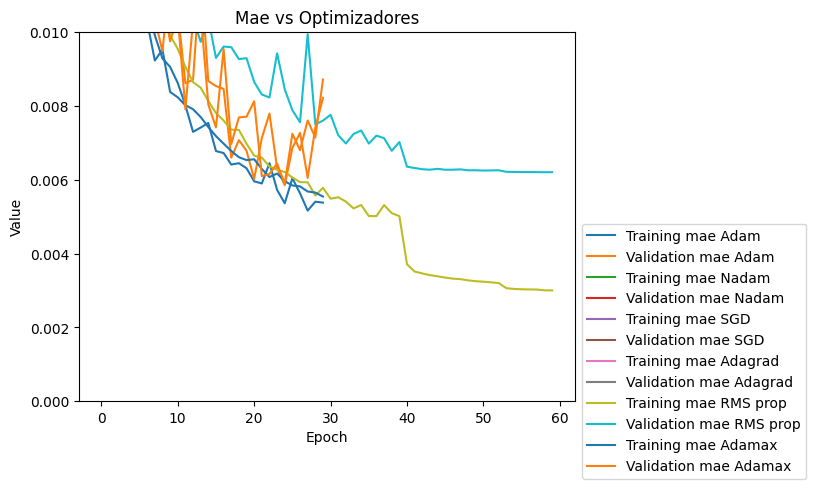

In [69]:
for optimizador_name, train_acc, val_acc in zip(optimizadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + optimizador_name)
  plt.plot(val_acc, label='Validation mae '+ optimizador_name)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0, 0.01)
plt.title('Mae vs Optimizadores')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()



## MAE vs Activaciones


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               100480    
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
235/235 [==============================] - 3s 6ms/step - loss: 0.1683 - mean_absolute_error: 0.1683 - val_loss: 0.1068 - val_mean_absolute_error: 0.1068 - lr: 0.0010
Epo

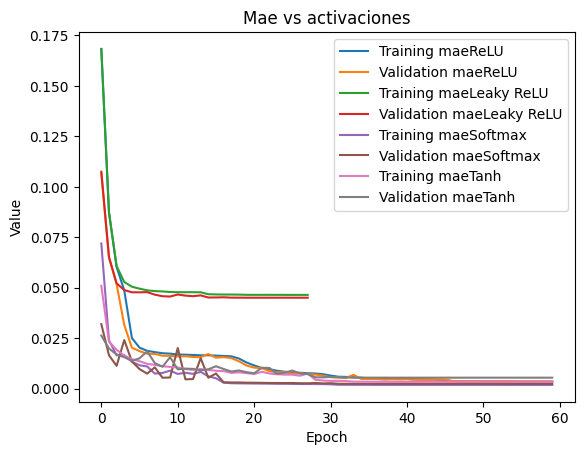

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=4)
activaciones = {'Softmax', 'ReLU', 'Tanh', 'Leaky ReLU'}

################### SOFTMAX ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'softmax'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'softmax'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()
train_acc_values = []
val_acc_values = []

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### ReLU ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'softmax'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'softmax'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])

train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### Tanh ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'tanh'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'tanh'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

# Train the model on the training data
history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### Leaky ReLU ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'leaky_relu'),
        #layers.Dropout(0.2),
        layers.Dense(64, activation = 'leaky_relu'),
        #layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])

for activacion, train_acc, val_acc in zip(activaciones, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae' + activacion)
  plt.plot(val_acc, label='Validation mae'+activacion)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Mae vs activaciones')
plt.legend()
plt.show()

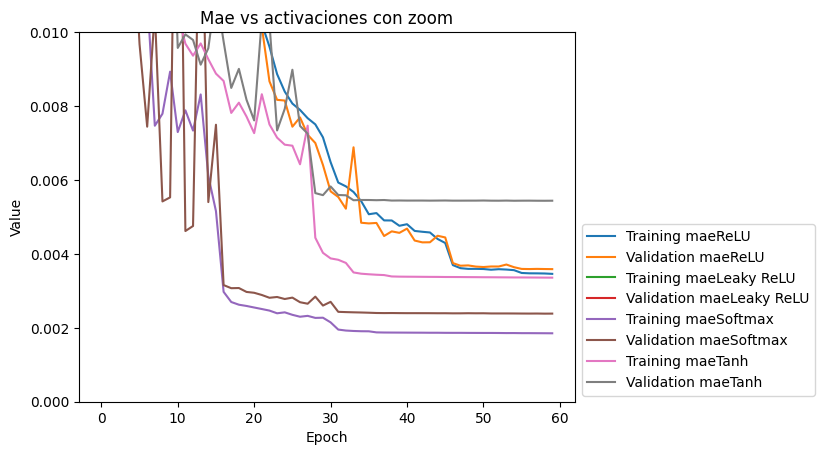

In [76]:
for activacion, train_acc, val_acc in zip(activaciones, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae' + activacion)
  plt.plot(val_acc, label='Validation mae'+activacion)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0, 0.01)
plt.title('Mae vs activaciones con zoom')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## MAE vs Dropout Rate

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 128)               100480    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-t

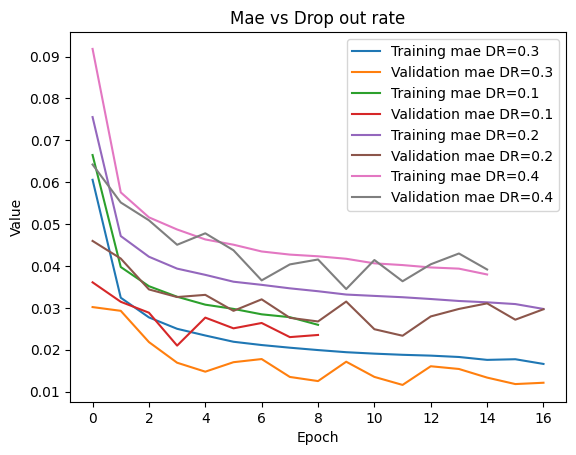

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=4)
drates = {'DR=0.1', 'DR=0.2', 'DR=0.3', 'DR=0.4'}

################### SOFTMAX ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()
train_acc_values = []
val_acc_values = []

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### ReLU ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### Tanh ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### Leaky ReLU ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation = 'relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])
history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])



for drate, train_acc, val_acc in zip(drates, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + drate)
  plt.plot(val_acc, label='Validation mae '+drate)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Mae vs Drop out rate')
plt.legend()
plt.show()

## MAE vs Batch Normalization

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 dense_72 (Dense)            (None, 128)               100480    
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dense_74 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
235/235 [==============================] - 2s 7ms/step - loss: 0.0475 - mean_absolute_error: 0.0475 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - lr: 0.0010
Ep

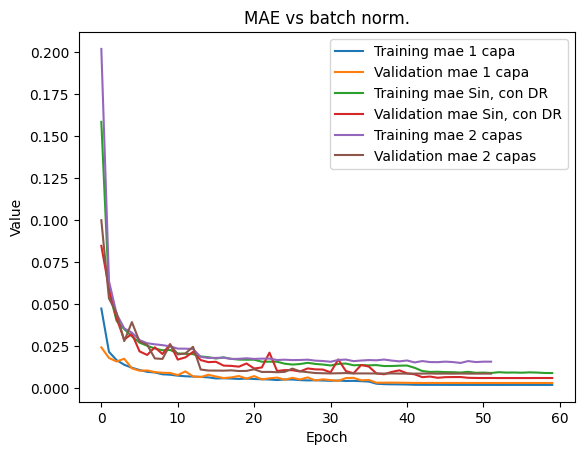

In [79]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=4)
batchNorm = {'Sin, con DR', '1 capa', '2 capas'}

################### Solo con DR ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()
train_acc_values = []
val_acc_values = []

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### Sin DR, 1 capa ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### 2 capas ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation = 'linear')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])

for batchN, train_acc, val_acc in zip(batchNorm, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + batchN)
  plt.plot(val_acc, label='Validation mae '+batchN)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs batch norm.')
plt.legend()
plt.show()

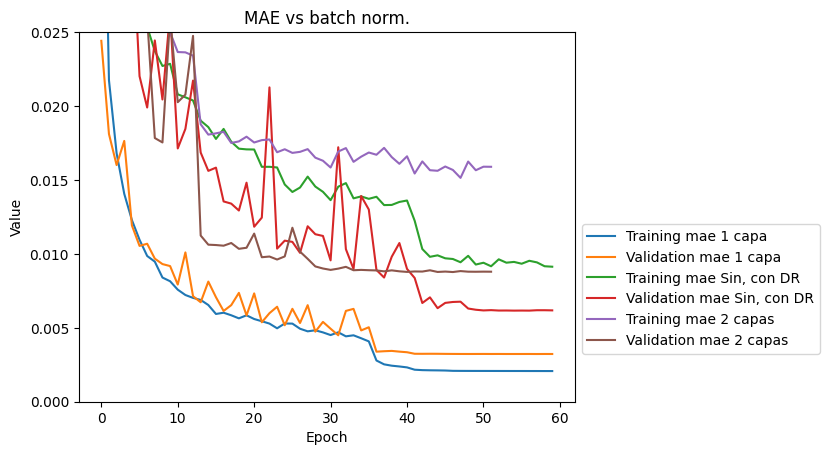

In [80]:
for batchN, train_acc, val_acc in zip(batchNorm, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + batchN)
  plt.plot(val_acc, label='Validation mae '+batchN)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs batch norm.')
plt.ylim(0, 0.025)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## MAE vs Inicializadores de peso

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 784)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               100480    
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dense_83 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
235/235 [==============================] - 2s 6ms/step - loss: 0.0485 - mean_absolute_error: 0.0485 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258 - lr: 0.0010
Ep

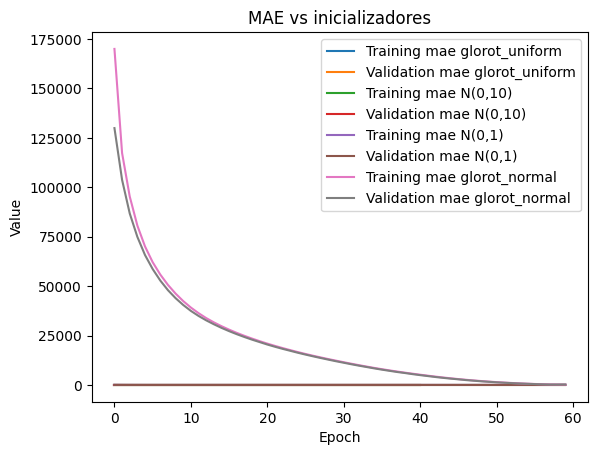

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

x_train_mlp = x_train.astype("float32") / 255.0
x_test_mlp = x_test.astype("float32") / 255.0

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6, patience=3)
inicializadores = {'glorot_uniform', 'glorot_normal', 'N(0,1)', 'N(0,10)'}

################### glorot uniform ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform'),
        layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform'),
        layers.Dense(1, activation = 'linear', kernel_initializer = 'glorot_uniform')
    ]
)
modelRegresion.summary()
train_acc_values = []
val_acc_values = []

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### glorot normal ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_normal'),
        layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_normal'),
        layers.Dense(1, activation = 'linear', kernel_initializer = 'glorot_normal')
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### N(0,1) ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dense(64, activation = 'relu', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)),
        layers.Dense(1, activation = 'linear', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0))
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])
################### N(0, 10) ##########################
modelRegresion = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dense(64, activation = 'relu', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10)),
        layers.Dense(1, activation = 'linear', kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=10))
    ]
)
modelRegresion.summary()

modelRegresion.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["mean_absolute_error"])

history = modelRegresion.fit(x_train_reg, y_train_slants, batch_size=256, epochs=60, validation_data = (x_test_reg, y_test_slants), callbacks = [reduce_lr, early_stopping])
train_acc_values.append(history.history['mean_absolute_error'])
val_acc_values.append(history.history['val_mean_absolute_error'])

for inicializador, train_acc, val_acc in zip(inicializadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + inicializador)
  plt.plot(val_acc, label='Validation mae '+ inicializador)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs inicializadores')
plt.legend()
plt.show()

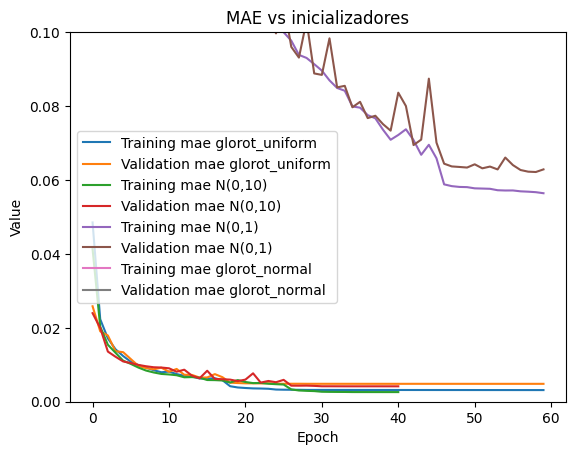

In [82]:
for inicializador, train_acc, val_acc in zip(inicializadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + inicializador)
  plt.plot(val_acc, label='Validation mae '+ inicializador)

plt.ylim(0, 0.1)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs inicializadores')
plt.legend()
plt.show()

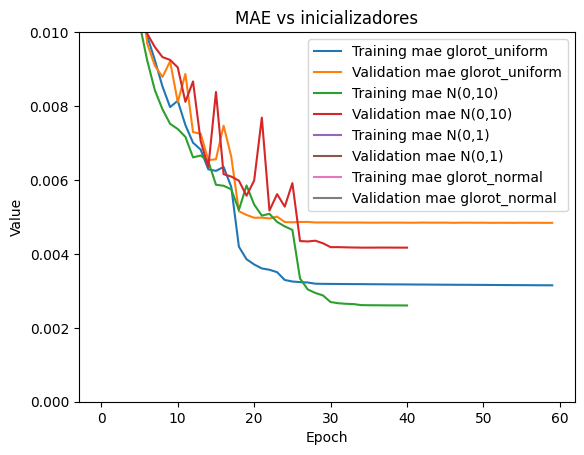

In [83]:
for inicializador, train_acc, val_acc in zip(inicializadores, train_acc_values, val_acc_values):
  plt.plot(train_acc, label='Training mae ' + inicializador)
  plt.plot(val_acc, label='Validation mae '+ inicializador)

plt.ylim(0, 0.01)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MAE vs inicializadores')
plt.legend()
plt.show()